In [359]:
import sys
sys.path.append('/Users/Valery/anaconda/envs/python3/lib/python3.5/site-packages')

In [360]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [361]:
import os
os.listdir("test_images/")

['extra.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [362]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [389]:
import math
import time
from operator import itemgetter

right_left_lanes = [(0,0),(0,0),(0,0), (0,0)]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny_auto_threshold(img,sigma=0.01):
    # median gray channel intensity
    #plt.imshow(image)
    x_center = image.shape[1]/2

    crop_y_t = 560
    crop_y_l = 660
    crop_x_r = x_center+500
    crop_x_l = x_center-500

    crop_img = image[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
    
    
    # calculate low and high threshold
    low_threshold = max(0, crop_img.mean()*2*(1-sigma))
    high_threshold = min(255, crop_img.max()*(1+sigma))   
    
    return (low_threshold, high_threshold)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def draw_lines(img, lines, right_left_lanes,color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #initialization
    
    #array initialization
    rt_lane_slopes = []
    lf_lane_slopes = []
    
    #var initialization
    rt_lines_pos = []
    lf_lines_pos = []
    
    for line in lines:
        for x1,y1,x2,y2 in line: 
            
            #remove
            cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
            
            pi = np.pi
            m = ((y2-y1)/(x2-x1))
            m_angle = np.arctan(m)
            x_center = image.shape[1]/2
            
            #right lane
            if m > 0.50 and m < 0.90 and x1>(x_center+50):
                #append slope values
                rt_lane_slopes.append(m)
                #append line positions
                rt_lines_pos.append((x1,y1))
                
            elif m < -0.60 and m > -0.90 and x2<(x_center-50):
                #append slope values
                lf_lane_slopes.append(m)
                #append line positions
                lf_lines_pos.append((x2,y2)) 
                         
    
    #drawing right lane
    print("right lane slopes:", rt_lane_slopes)
    if not rt_lines_pos:
        cv2.line(img,right_left_lanes[0],right_left_lanes[1], color, thickness)
    
    else:
        #filter points to stay within standard deviation threshold
        rt_lane_slopes = np.array(rt_lane_slopes)
    
        #rt_lane_slopes = reject_outliers(rt_lane_slopes, m=2)
    
        #average slopes
        rt_slope_avg = np.array(rt_lane_slopes).mean()
    
        #determine right lane position
        rt_lines_pos = sorted(rt_lines_pos, key=itemgetter(0))
        rt_lane_pos = rt_lines_pos[int(math.floor(len(rt_lines_pos)/2))]
        rt_top = rt_lines_pos[0]
    
        #set x/y position for right lane upper end
        rt_top_x = rt_top[0]
        rt_top_y = rt_top[1]
    
        rt_lw_y = image.shape[0]
    
        #calculate x position for right lane lower end
        print(rt_lw_y,rt_top_y,rt_slope_avg,rt_top_x)
        rt_lw_x = int(math.floor(((rt_lw_y - rt_top_y) / rt_slope_avg + rt_top_x)))
    
        cv2.line(img, (rt_lw_x, image.shape[0]), (rt_top_x, rt_top_y), color, thickness)
    
    #-----------------
    
    #drawing left lane
    print("left lane slopes:", lf_lane_slopes) 
    if not lf_lines_pos:
        cv2.line(img,right_left_lanes[2],right_left_lanes[3], color, thickness)
        return  
    
    else:
        #filter points to stay within standard deviation threshold
        lf_lane_slopes = np.array(lf_lane_slopes)
    
        #lf_lane_slopes = reject_outliers(lf_lane_slopes, m=2)
    
        #average slopes
        lf_slope_avg = np.array(lf_lane_slopes).mean()    

        #determine left lane position
        lf_lines_pos = sorted(lf_lines_pos, key=itemgetter(0))    
        lf_lane_pos = lf_lines_pos[int(math.floor(len(lf_lines_pos)/2))]
        lf_top = lf_lines_pos[int(len(lf_lines_pos)-1)]
    
        #set x/y position for left lane upper end
        lf_top_x = lf_top[0]
        lf_top_y = lf_top[1]
 
        lf_lw_y = image.shape[0]
    
        #calculate x position for left lane lower end
        lf_lw_x = int(math.floor((lf_lw_y - lf_top_y) / lf_slope_avg + lf_top_x))
    
        cv2.line(img, (lf_lw_x, image.shape[0]), (lf_top_x, lf_top_y), color, thickness)  
        
        right_left_lanes = [(lf_lw_x, image.shape[0]), (lf_top_x, lf_top_y),(lf_lw_x, image.shape[0]), (lf_top_x, lf_top_y)]
        return right_left_lanes

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,right_left_lanes):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    right_left_lanes = draw_lines(line_img, lines, right_left_lanes)
    print(right_left_lanes)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


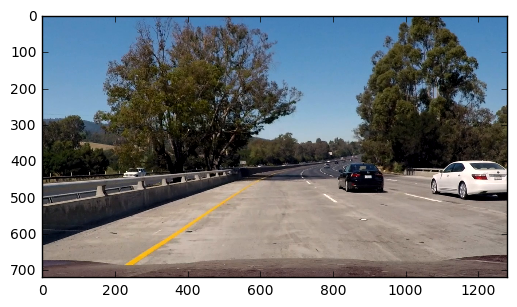

In [392]:
#reading in an image

#image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = VideoFileClip('challenge.mp4').get_frame(5)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

(100, 900, 3)


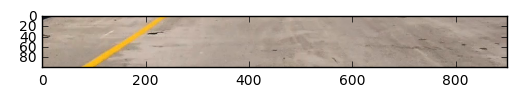

In [395]:
#test cell to remove
#plt.imshow(image)
x_center = image.shape[1]/2

crop_y_t = 560
crop_y_l = 660
crop_x_r = x_center+450
crop_x_l = x_center-450

crop_img = image[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
plt.imshow(crop_img)
print(crop_img.shape)

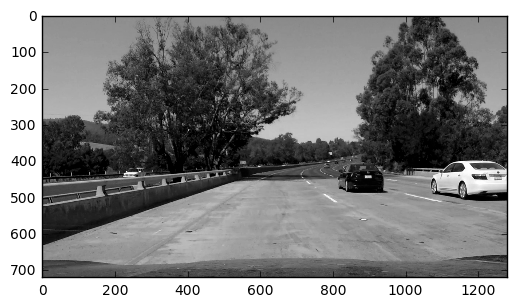

In [397]:
#reduce colored image to grayscaled image
image_grayed = grayscale(image)
plt.imshow(image_grayed, cmap='gray')

(312.90695040000003, 255)


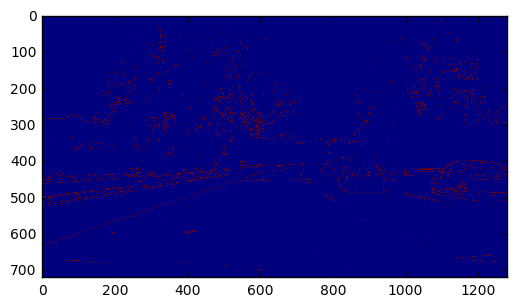

In [398]:
#apply canny to grayscaled image
canny_threshold = canny_auto_threshold(image_grayed)
image_canny = canny(image_grayed,canny_threshold[0],canny_threshold[1])
print(canny_threshold)
plt.imshow(image_canny)


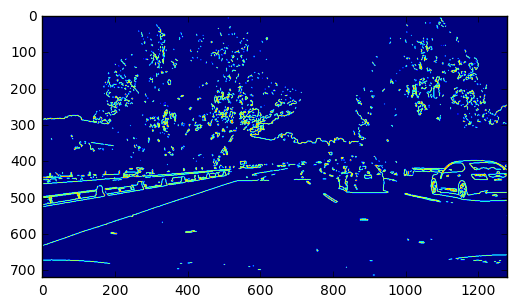

In [399]:
#apply gaussian blur to image
kernel_size = 5
image_gauss = gaussian_blur(image_canny,kernel_size)
plt.imshow(image_gauss)

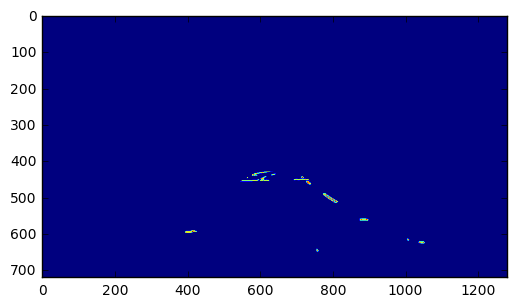

In [402]:
#pick area of interest
x_center = image.shape[1] / 2
top_left_v = (x_center-50,430)
low_left_v = (200,image.shape[0]-60)
top_right_v = (x_center+50,430)
low_right_v = (image.shape[1] - 150,image.shape[0]-60)
vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
image_mask = region_of_interest(image_gauss,vertices)
plt.imshow(image_mask)

right lane slopes: [0.88888888888888884, 0.72560975609756095, 0.875]
720 447 0.829832881662 711
left lane slopes: []
None


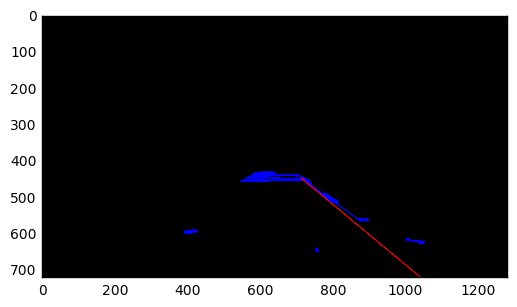

In [403]:
#determine hough lines
lines_hough = hough_lines(image_mask,0.5, np.pi/180, 5, 5, 80,right_left_lanes)
plt.imshow(lines_hough)

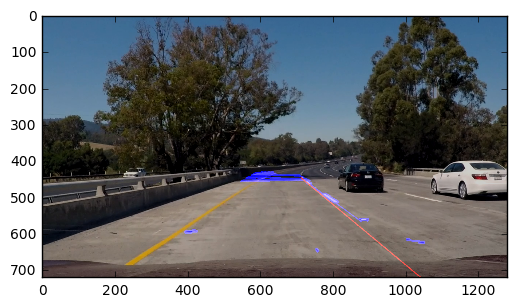

In [404]:
#Add weighed lines onto initial image
image_final = weighted_img(lines_hough,image)
plt.imshow(image_final)

In [405]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    image_grayed = grayscale(image)
    canny_threshold = canny_auto_threshold(image_grayed)
    image_canny = canny(image_grayed,canny_threshold[0],canny_threshold[1])
    kernel_size = 5
    image_gauss = gaussian_blur(image_canny,kernel_size)
    x_center = image.shape[1] / 2
    top_left_v = (x_center-50,430)
    low_left_v = (200,image.shape[0]-60)
    top_right_v = (x_center+50,430)
    low_right_v = (image.shape[1] - 150,image.shape[0]-60)
    vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
    image_mask = region_of_interest(image_gauss,vertices)
    lines_hough = hough_lines(image_mask,0.5, np.pi/180, 10, 5, 80,right_left_lanes)
    #lines_hough = hough_lines(image_mask,0.5, np.pi/180, 5, 5, 80)
    image_final = weighted_img(lines_hough,image)
    plt.imshow(image_final)
        
    return image_final

right lane slopes: [0.5957446808510638, 0.57857142857142863, 0.59829059829059827, 0.59859154929577463, 0.59859154929577463, 0.59848484848484851, 0.57931034482758625, 0.59999999999999998, 0.57971014492753625, 0.59677419354838712, 0.59999999999999998, 0.62931034482758619, 0.57377049180327866, 0.58119658119658124, 0.57931034482758625, 0.58181818181818179, 0.77884615384615385, 0.5977011494252874, 0.58024691358024694, 0.59259259259259256, 0.53333333333333333, 0.5934959349593496, 0.59999999999999998, 0.59999999999999998, 0.77777777777777779, 0.5757575757575758, 0.57823129251700678, 0.5321100917431193, 0.77884615384615385, 0.59842519685039375, 0.59375, 0.875, 0.53521126760563376, 0.52112676056338025, 0.875]
720 441 0.616769356485 711
left lane slopes: [-0.65420560747663548, -0.65420560747663548, -0.64864864864864868, -0.875, -0.64814814814814814, -0.67883211678832112, -0.6428571428571429, -0.68181818181818177, -0.65134099616858232, -0.72727272727272729, -0.78947368421052633, -0.72727272727272


  0%|          | 0/251 [00:00<?, ?it/s]

right lane slopes: [0.5957446808510638, 0.57857142857142863, 0.59829059829059827, 0.59859154929577463, 0.59859154929577463, 0.59848484848484851, 0.57931034482758625, 0.59999999999999998, 0.57971014492753625, 0.59677419354838712, 0.59999999999999998, 0.62931034482758619, 0.57377049180327866, 0.58119658119658124, 0.57931034482758625, 0.58181818181818179, 0.77884615384615385, 0.5977011494252874, 0.58024691358024694, 0.59259259259259256, 0.53333333333333333, 0.5934959349593496, 0.59999999999999998, 0.59999999999999998, 0.77777777777777779, 0.5757575757575758, 0.57823129251700678, 0.5321100917431193, 0.77884615384615385, 0.59842519685039375, 0.59375, 0.875, 0.53521126760563376, 0.52112676056338025, 0.875]
720 441 0.616769356485 711
left lane slopes: [-0.65420560747663548, -0.65420560747663548, -0.64864864864864868, -0.875, -0.64814814814814814, -0.67883211678832112, -0.6428571428571429, -0.68181818181818177, -0.65134099616858232, -0.72727272727272729, -0.78947368421052633, -0.72727272727272


  1%|          | 2/251 [00:00<00:22, 11.18it/s]

right lane slopes: [0.65517241379310343, 0.625, 0.55172413793103448, 0.55140186915887845, 0.57281553398058249, 0.55681818181818177, 0.62686567164179108, 0.62365591397849462, 0.58015267175572516, 0.55140186915887845, 0.55045871559633031, 0.63855421686746983, 0.64516129032258063, 0.55045871559633031, 0.61538461538461542, 0.53846153846153844, 0.55681818181818177, 0.53191489361702127, 0.61855670103092786, 0.55371900826446285, 0.59090909090909094, 0.58015267175572516, 0.55555555555555558, 0.62765957446808507, 0.55660377358490565, 0.55140186915887845, 0.53424657534246578, 0.625, 0.62831858407079644, 0.55405405405405406, 0.58163265306122447, 0.62790697674418605]
720 443 0.584623047465 712
left lane slopes: [-0.67512690355329952, -0.6711711711711712, -0.6071428571428571, -0.625, -0.67400881057268724, -0.70370370370370372, -0.7407407407407407, -0.65217391304347827, -0.66666666666666663, -0.68000000000000005, -0.70833333333333337, -0.69565217391304346, -0.64000000000000001, -0.80000000000000004,

right lane slopes: [0.59999999999999998, 0.59740259740259738, 0.58163265306122447, 0.59999999999999998, 0.625, 0.59740259740259738, 0.60402684563758391, 0.55000000000000004, 0.59459459459459463, 0.60130718954248363, 0.60526315789473684, 0.60526315789473684, 0.6216216216216216, 0.62686567164179108, 0.5757575757575758, 0.625, 0.61538461538461542, 0.61956521739130432, 0.59999999999999998, 0.58139534883720934, 0.66666666666666663, 0.59999999999999998, 0.63157894736842102, 0.6428571428571429, 0.625, 0.59999999999999998, 0.67741935483870963, 0.59999999999999998, 0.51111111111111107, 0.59999999999999998, 0.60869565217391308, 0.57894736842105265, 0.66666666666666663, 0.6216216216216216, 0.59999999999999998, 0.6228070175438597]
720 442 0.607801510926 712
left lane slopes: [-0.63043478260869568, -0.63, -0.62790697674418605, -0.6333333333333333, -0.65671641791044777, -0.625, -0.62790697674418605, -0.62765957446808507, -0.62318840579710144, -0.65384615384615385, -0.63043478260869568, -0.6315789473


  2%|▏         | 4/251 [00:00<00:22, 11.12it/s]

right lane slopes: [0.78350515463917525, 0.59999999999999998, 0.5641025641025641, 0.56097560975609762, 0.52941176470588236, 0.59782608695652173, 0.62962962962962965, 0.59999999999999998, 0.55555555555555558, 0.58252427184466016, 0.625, 0.55882352941176472]
720 443 0.59894618055 712
left lane slopes: [-0.6728395061728395, -0.67213114754098358, -0.67479674796747968, -0.67460317460317465, -0.69230769230769229, -0.83333333333333337, -0.75, -0.7142857142857143]
[(228, 720), (552, 490), (228, 720), (552, 490)]
right lane slopes: [0.5714285714285714, 0.5714285714285714, 0.72499999999999998, 0.56521739130434778, 0.57894736842105265, 0.59999999999999998, 0.57999999999999996, 0.57777777777777772, 0.56097560975609762, 0.59999999999999998, 0.60377358490566035, 0.5625, 0.58333333333333337]
720 442 0.590798631412 712
left lane slopes: [-0.67346938775510201, -0.6692913385826772, -0.69999999999999996, -0.66666666666666663, -0.66666666666666663, -0.69230769230769229, -0.83333333333333337, -0.8000000000


  2%|▏         | 6/251 [00:00<00:21, 11.36it/s]

right lane slopes: [0.62758620689655176, 0.625, 0.6223776223776224, 0.59615384615384615, 0.60869565217391308, 0.62328767123287676, 0.60377358490566035, 0.59999999999999998, 0.58064516129032262, 0.65384615384615385, 0.60869565217391308, 0.625, 0.62328767123287676, 0.59999999999999998, 0.58823529411764708]
720 444 0.61243896776 713
left lane slopes: [-0.67400881057268724, -0.65359477124183007, -0.67961165048543692, -0.67699115044247793, -0.64864864864864868, -0.67213114754098358, -0.80000000000000004, -0.67000000000000004, -0.67213114754098358, -0.65467625899280579, -0.69230769230769229, -0.6741071428571429, -0.65217391304347827, -0.64963503649635035, -0.66666666666666663, -0.67567567567567566, -0.7142857142857143, -0.67241379310344829]
[(226, 720), (557, 496), (226, 720), (557, 496)]
right lane slopes: [0.67469879518072284, 0.59677419354838712, 0.67272727272727273, 0.63414634146341464, 0.57926829268292679]
720 442 0.631522979121 713
left lane slopes: [-0.68253968253968256, -0.6666666666


  3%|▎         | 8/251 [00:00<00:21, 11.37it/s]

right lane slopes: [0.62244897959183676, 0.62311557788944727, 0.6216216216216216, 0.6262626262626263, 0.6262626262626263, 0.62732919254658381, 0.62962962962962965, 0.62295081967213117, 0.6071428571428571, 0.62303664921465973]
720 444 0.622980057983 714
left lane slopes: [-0.62557077625570778, -0.651685393258427, -0.60089686098654704, -0.64864864864864868, -0.62385321100917435, -0.68000000000000005, -0.65384615384615385, -0.62666666666666671, -0.65000000000000002, -0.60273972602739723, -0.625, -0.67241379310344829, -0.65765765765765771, -0.62616822429906538, -0.65000000000000002]
[(209, 720), (530, 515), (209, 720), (530, 515)]



  4%|▍         | 10/251 [00:00<00:20, 11.86it/s]

right lane slopes: [0.62447257383966248, 0.62244897959183676, 0.62365591397849462, 0.64935064935064934, 0.57894736842105265, 0.59999999999999998, 0.62441314553990612, 0.59999999999999998, 0.61971830985915488, 0.63076923076923075, 0.62195121951219512, 0.67021276595744683]
720 444 0.622161679735 714
left lane slopes: [-0.72272727272727277, -0.72538860103626945, -0.72483221476510062, -0.72514619883040932, -0.75298804780876494, -0.7191011235955056, -0.72246696035242286, -0.75298804780876494, -0.72727272727272729, -0.72625698324022347, -0.72727272727272729, -0.69999999999999996, -0.75, -0.72636815920398012]
[(195, 720), (580, 440), (195, 720), (580, 440)]


right lane slopes: [0.65090909090909088, 0.62445414847161573, 0.58823529411764708, 0.64893617021276595, 0.62365591397849462, 0.60251046025104604, 0.6262626262626263, 0.66666666666666663, 0.55102040816326525, 0.59999999999999998, 0.60079051383399207, 0.61538461538461542, 0.58333333333333337]
720 443 0.614012249353 714
left lane slopes: [-0.69934640522875813, -0.70440251572327039, -0.74193548387096775, -0.69871794871794868, -0.77777777777777779, -0.69999999999999996, -0.69999999999999996, -0.69871794871794868, -0.7142857142857143, -0.72380952380952379, -0.80000000000000004, -0.7142857142857143, -0.77777777777777779]
[(246, 720), (572, 483), (246, 720), (572, 483)]
right lane slopes: [0.59523809523809523, 0.59880239520958078, 0.59210526315789469, 0.62461538461538457, 0.62580645161290327, 0.59999999999999998, 0.61111111111111116, 0.63043478260869568, 0.59880239520958078, 0.62393162393162394, 0.6012861736334405, 0.60070671378091878]
720 444 0.608570032509 715
left lane slopes: [-0.7265625, 


  5%|▍         | 12/251 [00:01<00:19, 12.04it/s]

right lane slopes: [0.6198347107438017, 0.61788617886178865, 0.62015503875968991, 0.60465116279069764, 0.62015503875968991, 0.624, 0.62184873949579833, 0.59848484848484851, 0.62204724409448819, 0.58823529411764708, 0.6198347107438017, 0.6179775280898876, 0.59677419354838712, 0.61111111111111116, 0.62393162393162394, 0.57894736842105265, 0.6470588235294118, 0.58730158730158732, 0.625, 0.59999999999999998, 0.64473684210526316, 0.6015625, 0.61111111111111116, 0.59999999999999998, 0.60396039603960394, 0.57692307692307687]
720 444 0.610904966499 714
left lane slopes: [-0.83536585365853655, -0.70422535211267601, -0.70642201834862384, -0.75, -0.60869565217391308, -0.72222222222222221, -0.70588235294117652, -0.72727272727272729, -0.72727272727272729, -0.68421052631578949, -0.72727272727272729, -0.75, -0.61538461538461542, -0.69791666666666663, -0.75, -0.70270270270270274]
[(221, 720), (498, 523), (221, 720), (498, 523)]



  6%|▌         | 14/251 [00:01<00:21, 10.88it/s]

right lane slopes: [0.53389830508474578, 0.53333333333333333, 0.620253164556962, 0.61627906976744184, 0.5535714285714286, 0.61855670103092786, 0.60240963855421692, 0.63043478260869568, 0.55454545454545456, 0.61904761904761907, 0.70078740157480313, 0.52892561983471076, 0.5730337078651685, 0.55045871559633031, 0.55670103092783507, 0.69767441860465118, 0.52941176470588236, 0.69599999999999995, 0.61250000000000004, 0.62337662337662336, 0.53333333333333333, 0.54166666666666663, 0.6271186440677966, 0.62184873949579833, 0.75362318840579712, 0.62666666666666671]
720 443 0.602132923778 714
left lane slopes: [-0.75, -0.72340425531914898, -0.80645161290322576, -0.78000000000000003, -0.77884615384615385, -0.77500000000000002, -0.72222222222222221, -0.74193548387096775, -0.78481012658227844, -0.7846153846153846, -0.72093023255813948, -0.75, -0.77685950413223137, -0.74358974358974361, -0.76190476190476186, -0.76086956521739135, -0.7767857142857143, -0.65384615384615385, -0.75, -0.77647058823529413, 


  6%|▋         | 16/251 [00:01<00:20, 11.21it/s]

right lane slopes: [0.72448979591836737, 0.65765765765765771, 0.5714285714285714, 0.6517857142857143, 0.59459459459459463, 0.53846153846153844, 0.64878048780487807, 0.72527472527472525, 0.6428571428571429, 0.60869565217391308, 0.62244897959183676, 0.63636363636363635, 0.58823529411764708, 0.65094339622641506, 0.63043478260869568, 0.72164948453608246]
720 442 0.638381340869 713
left lane slopes: [-0.72248803827751196, -0.78125, -0.72413793103448276, -0.78087649402390436, -0.78189300411522633, -0.72398190045248867]
[(242, 720), (588, 460), (242, 720), (588, 460)]



  7%|▋         | 18/251 [00:01<00:20, 11.30it/s]

right lane slopes: [0.69918699186991873, 0.62790697674418605, 0.625, 0.62601626016260159, 0.65384615384615385, 0.58823529411764708, 0.5714285714285714, 0.57798165137614677, 0.57894736842105265, 0.67307692307692313, 0.59999999999999998, 0.65217391304347827]
720 442 0.622816675341 713
left lane slopes: [-0.70192307692307687, -0.7009345794392523, -0.65789473684210531, -0.68000000000000005, -0.71153846153846156, -0.70422535211267601, -0.66176470588235292, -0.7142857142857143, -0.65789473684210531, -0.6741573033707865, -0.70370370370370372, -0.69999999999999996, -0.6987951807228916]
[(209, 720), (530, 499), (209, 720), (530, 499)]
right lane slopes: [0.7021276595744681, 0.69930069930069927, 0.70289855072463769, 0.65217391304347827, 0.69999999999999996, 0.73076923076923073, 0.7142857142857143, 0.68421052631578949, 0.7142857142857143, 0.71999999999999997, 0.703125, 0.65217391304347827, 0.625, 0.69999999999999996]
720 443 0.692882208667 713
left lane slopes: [-0.72649572649572647, -0.730769230


  8%|▊         | 20/251 [00:01<00:19, 11.66it/s]

right lane slopes: [0.61904761904761907, 0.671875, 0.6737967914438503, 0.66666666666666663, 0.67261904761904767, 0.63461538461538458, 0.66666666666666663, 0.6706586826347305, 0.63636363636363635, 0.67469879518072284]
720 431 0.658700829024 692
left lane slopes: [-0.72352941176470587, -0.72538860103626945, -0.72440944881889768, -0.72511848341232232, -0.73239436619718312, -0.72653061224489801, -0.67088607594936711, -0.72413793103448276, -0.7533333333333333]
[(230, 720), (574, 472), (230, 720), (574, 472)]


right lane slopes: [0.67179487179487174, 0.60256410256410253, 0.67346938775510201, 0.73913043478260865, 0.67500000000000004, 0.67452830188679247, 0.68354430379746833, 0.7567567567567568, 0.58333333333333337, 0.66666666666666663, 0.625]
720 432 0.668344378122 694
left lane slopes: [-0.72352941176470587, -0.69999999999999996, -0.72619047619047616, -0.72375690607734811, -0.72413793103448276, -0.625, -0.72839506172839508, -0.72580645161290325, -0.69999999999999996, -0.73529411764705888]
[(254, 720), (524, 528), (254, 720), (524, 528)]
right lane slopes: [0.64423076923076927, 0.60204081632653061, 0.64772727272727271, 0.65048543689320393, 0.62666666666666671, 0.64646464646464652, 0.62857142857142856, 0.77868852459016391, 0.65048543689320393, 0.65106382978723409, 0.62222222222222223, 0.6067415730337079, 0.6470588235294118, 0.64772727272727271]
720 445 0.646441051405 715
left lane slopes: [-0.70454545454545459, -0.69886363636363635, -0.69999999999999996, -0.67582417582417587, -0.67455621301775


  9%|▉         | 22/251 [00:01<00:19, 11.90it/s]

right lane slopes: [0.64777327935222673, 0.60139860139860135, 0.7142857142857143, 0.60096153846153844, 0.57971014492753625, 0.6015625, 0.60526315789473684, 0.61403508771929827, 0.60207612456747406, 0.60165975103734437, 0.60301507537688437, 0.58064516129032262]
720 457 0.612698844693 722
left lane slopes: [-0.77777777777777779, -0.70414201183431957, -0.72727272727272729, -0.77777777777777779, -0.88135593220338981, -0.63636363636363635, -0.78333333333333333, -0.63157894736842102, -0.61363636363636365, -0.69565217391304346, -0.70238095238095233]
[(244, 720), (504, 533), (244, 720), (504, 533)]



 10%|▉         | 24/251 [00:02<00:18, 12.16it/s]

right lane slopes: [0.59756097560975607, 0.60082304526748975, 0.59756097560975607, 0.59740259740259738, 0.61739130434782608, 0.62406015037593987, 0.59861591695501726, 0.61842105263157898, 0.61538461538461542, 0.60126582278481011, 0.62295081967213117, 0.62365591397849462, 0.61904761904761907, 0.6216216216216216, 0.55555555555555558, 0.60248447204968947, 0.62790697674418605, 0.60365853658536583]
720 457 0.608075998424 722
left lane slopes: [-0.67460317460317465, -0.62142857142857144, -0.68000000000000005, -0.69999999999999996, -0.69841269841269837, -0.671875, -0.62142857142857144, -0.69999999999999996, -0.71999999999999997, -0.67226890756302526, -0.80263157894736847, -0.62857142857142856, -0.8441558441558441, -0.73076923076923073, -0.84210526315789469, -0.83783783783783783, -0.70512820512820518, -0.62893081761006286]
[(240, 720), (502, 534), (240, 720), (502, 534)]
right lane slopes: [0.65254237288135597, 0.57894736842105265, 0.625, 0.55000000000000004, 0.57352941176470584, 0.57352941176


 10%|█         | 26/251 [00:02<00:18, 12.44it/s]

right lane slopes: [0.62195121951219512, 0.67669172932330823, 0.5714285714285714, 0.61971830985915488, 0.55555555555555558, 0.61250000000000004, 0.65333333333333332, 0.61538461538461542, 0.69444444444444442, 0.625, 0.61445783132530118, 0.625, 0.60810810810810811, 0.69863013698630139, 0.58024691358024694, 0.67142857142857137, 0.57851239669421484, 0.60606060606060608, 0.59090909090909094, 0.62195121951219512, 0.59701492537313428, 0.67142857142857137, 0.671875, 0.59375, 0.6470588235294118, 0.550561797752809, 0.69863013698630139]
720 444 0.624875255871 714
left lane slopes: [-0.66216216216216217, -0.65217391304347827, -0.65000000000000002, -0.67567567567567566, -0.68000000000000005, -0.65822784810126578, -0.67741935483870963, -0.64880952380952384, -0.6767676767676768, -0.71794871794871795, -0.69230769230769229, -0.65789473684210531, -0.6785714285714286, -0.67441860465116277, -0.64848484848484844, -0.71999999999999997, -0.69230769230769229, -0.70833333333333337]
[(226, 720), (493, 540), (22


 11%|█         | 28/251 [00:02<00:17, 12.80it/s]

right lane slopes: [0.57692307692307687, 0.55882352941176472, 0.61538461538461542, 0.53846153846153844, 0.59999999999999998, 0.53846153846153844, 0.6428571428571429, 0.64935064935064934, 0.58252427184466016, 0.64827586206896548, 0.63157894736842102, 0.54545454545454541, 0.63157894736842102, 0.58064516129032262, 0.5714285714285714, 0.62068965517241381, 0.57857142857142863]
720 444 0.594765263613 714
left lane slopes: [-0.72300469483568075, -0.7078651685393258, -0.72340425531914898, -0.72727272727272729, -0.72549019607843135, -0.72602739726027399, -0.73043478260869565, -0.73333333333333328, -0.72580645161290325]
[(220, 720), (516, 506), (220, 720), (516, 506)]
right lane slopes: [0.65024630541871919, 0.55462184873949583, 0.65000000000000002, 0.57851239669421484, 0.625, 0.63636363636363635, 0.59663865546218486, 0.64814814814814814, 0.66666666666666663, 0.62962962962962965]
720 431 0.623582728712 692
left lane slopes: [-0.75555555555555554, -0.7021276595744681, -0.75342465753424659, -0.751

right lane slopes: [0.69902912621359226, 0.55319148936170215, 0.72340425531914898, 0.59999999999999998, 0.55555555555555558, 0.66972477064220182, 0.57499999999999996, 0.67567567567567566, 0.57692307692307687, 0.65413533834586468, 0.55813953488372092, 0.59999999999999998, 0.83783783783783783]
720 431 0.636816666212 692
left lane slopes: [-0.70270270270270274, -0.70289855072463769, -0.70526315789473681, -0.7068965517241379, -0.70036101083032487, -0.69696969696969702, -0.68421052631578949]
[(223, 720), (586, 466), (223, 720), (586, 466)]



 12%|█▏        | 30/251 [00:02<00:17, 12.65it/s]

right lane slopes: [0.58823529411764708, 0.67333333333333334, 0.61538461538461542, 0.65354330708661412, 0.61363636363636365, 0.59999999999999998, 0.69999999999999996, 0.61111111111111116, 0.69230769230769229, 0.67226890756302526]
720 431 0.641982062454 692
left lane slopes: [-0.70129870129870131, -0.70053475935828879, -0.70181818181818179, -0.75103734439834025, -0.69999999999999996, -0.75396825396825395, -0.752, -0.75103734439834025, -0.75100401606425704, -0.7544642857142857]
[(235, 720), (581, 467), (235, 720), (581, 467)]
right lane slopes: [0.61904761904761907, 0.61111111111111116, 0.62637362637362637, 0.57692307692307687, 0.62264150943396224, 0.61538461538461542, 0.65100671140939592, 0.625, 0.60869565217391308, 0.62962962962962965, 0.62637362637362637, 0.61111111111111116, 0.6470588235294118, 0.64912280701754388, 0.6506024096385542, 0.63157894736842102]
720 431 0.625103829783 692
left lane slopes: [-0.62447257383966248, -0.67826086956521736, -0.65333333333333332, -0.678571428571428


 14%|█▎        | 34/251 [00:02<00:17, 12.62it/s]

right lane slopes: [0.64628820960698685, 0.56818181818181823, 0.64573991031390132, 0.67357512953367871, 0.6376811594202898, 0.64566929133858264, 0.64444444444444449, 0.6974358974358974, 0.64912280701754388, 0.69696969696969702, 0.6484375, 0.6470588235294118]
720 431 0.650050390649 692
left lane slopes: [-0.75496688741721851, -0.72413793103448276, -0.75, -0.77450980392156865, -0.77948717948717949, -0.78142076502732238, -0.71818181818181814, -0.74825174825174823, -0.75316455696202533, -0.78010471204188481, -0.69230769230769229, -0.75167785234899331, -0.72727272727272729, -0.66666666666666663, -0.71641791044776115, -0.66666666666666663, -0.72727272727272729, -0.75, -0.7142857142857143, -0.7142857142857143, -0.66666666666666663, -0.77272727272727271, -0.7142857142857143, -0.75167785234899331, -0.77941176470588236]
[(190, 720), (566, 444), (190, 720), (566, 444)]
right lane slopes: [0.67261904761904767, 0.65027322404371579, 0.70040485829959509, 0.67391304347826086, 0.65053763440860213, 0.67

right lane slopes: [0.69999999999999996, 0.697508896797153, 0.70070422535211263, 0.57971014492753625, 0.69824561403508767, 0.70050761421319796, 0.70270270270270274, 0.77419354838709675, 0.57641921397379914, 0.70434782608695656, 0.69897959183673475, 0.69999999999999996, 0.65277777777777779, 0.57894736842105265]
720 433 0.676074608894 696
left lane slopes: [-0.6227544910179641, -0.67096774193548392, -0.67403314917127077, -0.67096774193548392, -0.63636363636363635, -0.67096774193548392, -0.67241379310344829, -0.69999999999999996, -0.66666666666666663, -0.67272727272727273, -0.6785714285714286, -0.73333333333333328, -0.676056338028169, -0.69999999999999996, -0.66666666666666663, -0.6785714285714286, -0.63636363636363635, -0.67532467532467533, -0.67763157894736847, -0.66666666666666663, -0.69230769230769229, -0.6428571428571429, -0.72727272727272729]
[(163, 720), (576, 442), (163, 720), (576, 442)]



 14%|█▍        | 36/251 [00:03<00:17, 11.97it/s]

right lane slopes: [0.6216216216216216, 0.6216216216216216, 0.62589928057553956, 0.61940298507462688, 0.61971830985915488, 0.625, 0.67123287671232879, 0.63636363636363635, 0.64473684210526316, 0.74747474747474751, 0.6223776223776224, 0.625, 0.66666666666666663, 0.61290322580645162, 0.625, 0.62745098039215685, 0.62376237623762376, 0.6216216216216216, 0.65000000000000002, 0.647887323943662, 0.625, 0.65517241379310343, 0.64383561643835618, 0.59999999999999998]
720 434 0.636656240362 698
left lane slopes: [-0.62189054726368154, -0.62721893491124259, -0.69999999999999996, -0.6262626262626263, -0.63636363636363635, -0.63095238095238093, -0.625, -0.65555555555555556, -0.66666666666666663, -0.63218390804597702, -0.61111111111111116, -0.64615384615384619, -0.63636363636363635, -0.69999999999999996, -0.69999999999999996, -0.66666666666666663]
[(140, 720), (563, 446), (140, 720), (563, 446)]
right lane slopes: [0.55118110236220474, 0.6216216216216216, 0.61682242990654201, 0.53846153846153844, 0.6


 15%|█▌        | 38/251 [00:03<00:18, 11.39it/s]

right lane slopes: [0.5495495495495496, 0.69942196531791911, 0.6262626262626263, 0.69736842105263153, 0.5495495495495496, 0.6262626262626263, 0.625, 0.55660377358490565]
720 432 0.616252313947 694
left lane slopes: [-0.65040650406504064, -0.67088607594936711, -0.65322580645161288, -0.6506024096385542, -0.67441860465116277, -0.68292682926829273, -0.67256637168141598, -0.65079365079365081, -0.80000000000000004, -0.67364016736401677, -0.67500000000000004]
[(201, 720), (529, 498), (201, 720), (529, 498)]
right lane slopes: [0.70050761421319796, 0.75, 0.6470588235294118, 0.62222222222222223, 0.64655172413793105, 0.65034965034965031]
720 431 0.669448339075 692
left lane slopes: [-0.63218390804597702, -0.63218390804597702, -0.64893617021276595, -0.65765765765765771, -0.62820512820512819, -0.62962962962962965, -0.61971830985915488, -0.64835164835164838, -0.63013698630136983, -0.64948453608247425, -0.625, -0.65277777777777779, -0.64893617021276595]
[(208, 720), (467, 555), (208, 720), (467, 555


 16%|█▌        | 40/251 [00:03<00:18, 11.61it/s]

right lane slopes: [0.75, 0.67521367521367526, 0.7142857142857143, 0.71999999999999997, 0.75206611570247939, 0.71962616822429903, 0.72566371681415931, 0.75471698113207553, 0.72222222222222221, 0.7232142857142857, 0.69724770642201839, 0.73076923076923073, 0.73015873015873012, 0.72222222222222221, 0.72566371681415931]
720 433 0.724204699046 696
left lane slopes: [-0.69948186528497414, -0.69767441860465118, -0.69756097560975605, -0.73913043478260865, -0.69613259668508287, -0.69672131147540983, -0.69827586206896552, -0.69955156950672648, -0.69696969696969702, -0.69999999999999996, -0.71999999999999997, -0.69863013698630139, -0.69354838709677424]
[(216, 720), (541, 492), (216, 720), (541, 492)]



 17%|█▋        | 42/251 [00:03<00:18, 11.08it/s]

right lane slopes: [0.59999999999999998, 0.61904761904761907, 0.65100671140939592, 0.63157894736842102, 0.61904761904761907, 0.61111111111111116, 0.59999999999999998, 0.6470588235294118, 0.7142857142857143, 0.64935064935064934, 0.63043478260869568, 0.64968152866242035, 0.61224489795918369]
720 432 0.63344987726 692
left lane slopes: [-0.65573770491803274, -0.6333333333333333, -0.625, -0.625, -0.62666666666666671, -0.625, -0.62820512820512819, -0.62264150943396224, -0.64864864864864868, -0.63414634146341464, -0.63492063492063489, -0.61111111111111116]
[(179, 720), (492, 523), (179, 720), (492, 523)]
right lane slopes: [0.64772727272727271, 0.64739884393063585, 0.67441860465116277, 0.69736842105263153, 0.65384615384615385, 0.65131578947368418, 0.69999999999999996, 0.65151515151515149]
720 433 0.66544877965 691
left lane slopes: [-0.625, -0.62702702702702706, -0.62184873949579833, -0.64912280701754388, -0.6517857142857143, -0.63265306122448983, -0.651685393258427, -0.67567567567567566, -0


 18%|█▊        | 44/251 [00:03<00:20, 10.27it/s]

right lane slopes: [0.64878048780487807, 0.64824120603015079, 0.61971830985915488, 0.61739130434782608, 0.65384615384615385, 0.64406779661016944, 0.64878048780487807]
720 432 0.640117963758 693
left lane slopes: [-0.67441860465116277, -0.67741935483870963, -0.68253968253968256, -0.66666666666666663, -0.67400881057268724, -0.67441860465116277, -0.81818181818181823]
[(230, 720), (577, 479), (230, 720), (577, 479)]
right lane slopes: [0.67543859649122806, 0.67256637168141598, 0.67298578199052128, 0.64130434782608692, 0.67142857142857137, 0.67298578199052128, 0.67441860465116277, 0.647887323943662, 0.69863013698630139, 0.66666666666666663, 0.69841269841269837]
720 433 0.67206589837 696
left lane slopes: [-0.67368421052631577, -0.68181818181818177, -0.67272727272727273, -0.65573770491803274, -0.7010309278350515, -0.67368421052631577, -0.72727272727272729]
[(242, 720), (515, 534), (242, 720), (515, 534)]
right lane slopes: [0.67286245353159846, 0.69902912621359226, 0.67460317460317465, 0.672


 18%|█▊        | 46/251 [00:04<00:19, 10.29it/s]

right lane slopes: [0.53149606299212604, 0.53305785123966942, 0.61904761904761907, 0.64985163204747776, 0.62295081967213117, 0.64666666666666661, 0.6470588235294118, 0.62566844919786091, 0.64473684210526316, 0.6462585034013606, 0.64776119402985077, 0.6470588235294118, 0.64473684210526316, 0.64754098360655743, 0.64197530864197527, 0.65306122448979587, 0.65079365079365081, 0.625]
720 433 0.629151183172 696
left lane slopes: [-0.62585034013605445, -0.6262626262626263, -0.63157894736842102, -0.6271186440677966, -0.62420382165605093, -0.62686567164179108, -0.6257309941520468, -0.6470588235294118, -0.60576923076923073, -0.62420382165605093, -0.62179487179487181, -0.71186440677966101, -0.66666666666666663, -0.62222222222222223, -0.6243386243386243, -0.63025210084033612, -0.6262626262626263, -0.75438596491228072, -0.69230769230769229, -0.62621359223300976, -0.75438596491228072, -0.75, -0.62179487179487181, -0.76363636363636367, -0.81132075471698117, -0.63636363636363635, -0.77358490566037741, 


 19%|█▉        | 48/251 [00:04<00:22,  8.98it/s]

right lane slopes: [0.62376237623762376, 0.65000000000000002, 0.64948453608247425, 0.625, 0.64948453608247425, 0.5730337078651685, 0.60377358490566035, 0.61728395061728392, 0.64948453608247425, 0.59999999999999998, 0.57425742574257421, 0.61764705882352944, 0.62365591397849462, 0.57943925233644855, 0.61956521739130432, 0.6428571428571429, 0.72932330827067671, 0.62886597938144329, 0.61194029850746268, 0.60526315789473684, 0.67368421052631577, 0.62295081967213117, 0.6428571428571429, 0.77570093457943923, 0.69911504424778759, 0.64948453608247425]
720 435 0.636073641193 696
left lane slopes: [-0.67938931297709926, -0.64000000000000001, -0.65277777777777779, -0.81818181818181823, -0.67567567567567566, -0.66666666666666663, -0.64864864864864868, -0.63636363636363635, -0.69230769230769229, -0.66666666666666663, -0.72727272727272729, -0.66666666666666663, -0.68421052631578949, -0.64864864864864868, -0.65789473684210531]
[(159, 720), (570, 442), (159, 720), (570, 442)]



 20%|█▉        | 50/251 [00:04<00:22,  9.09it/s]

right lane slopes: [0.56603773584905659, 0.61702127659574468, 0.55769230769230771, 0.6470588235294118, 0.60493827160493829, 0.60869565217391308, 0.61702127659574468, 0.63636363636363635, 0.60526315789473684, 0.58536585365853655, 0.58823529411764708, 0.57777777777777772, 0.61224489795918369, 0.61702127659574468, 0.60526315789473684, 0.57777777777777772, 0.6071428571428571, 0.625, 0.55319148936170215, 0.66666666666666663, 0.57608695652173914, 0.59999999999999998, 0.56862745098039214, 0.63157894736842102, 0.68181818181818177, 0.60869565217391308, 0.62337662337662336]
720 436 0.606146777759 697
left lane slopes: [-0.70731707317073167, -0.70422535211267601, -0.66666666666666663, -0.65625, -0.84210526315789469, -0.63636363636363635, -0.73076923076923073, -0.68965517241379315, -0.65625, -0.67469879518072284, -0.70270270270270274, -0.66666666666666663, -0.72727272727272729, -0.71999999999999997, -0.69999999999999996, -0.75, -0.66666666666666663, -0.7857142857142857, -0.65000000000000002]
[(232


 20%|██        | 51/251 [00:04<00:22,  8.80it/s]

right lane slopes: [0.70114942528735635, 0.8089887640449438, 0.69620253164556967, 0.72435897435897434, 0.69934640522875813, 0.75247524752475248, 0.69938650306748462, 0.67441860465116277, 0.70344827586206893, 0.5304347826086957, 0.7021276595744681, 0.69999999999999996]
720 436 0.699361431155 697
left lane slopes: [-0.69780219780219777, -0.72727272727272729, -0.69930069930069927, -0.83333333333333337, -0.72611464968152861, -0.83333333333333337]
[(249, 720), (552, 492), (249, 720), (552, 492)]


right lane slopes: [0.67326732673267331, 0.67317073170731712, 0.625, 0.671875, 0.62698412698412698, 0.63636363636363635, 0.67195767195767198, 0.65517241379310343, 0.62809917355371903, 0.6737967914438503, 0.61538461538461542, 0.67500000000000004]
720 435 0.652172623993 699
left lane slopes: [-0.70114942528735635, -0.72131147540983609, -0.76666666666666672, -0.75, -0.75384615384615383, -0.68571428571428572, -0.69999999999999996, -0.68421052631578949, -0.65322580645161288]
[(227, 720), (556, 486), (227, 720), (556, 486)]



 21%|██        | 53/251 [00:04<00:26,  7.45it/s]

right lane slopes: [0.60465116279069764, 0.6097560975609756, 0.70338983050847459, 0.61363636363636365, 0.63636363636363635, 0.61290322580645162, 0.69827586206896552, 0.62365591397849462]
720 444 0.637829011589 716
left lane slopes: [-0.69536423841059603, -0.8125, -0.69963369963369959, -0.75396825396825395, -0.75, -0.75316455696202533]
[(246, 720), (584, 469), (246, 720), (584, 469)]



 22%|██▏       | 54/251 [00:05<00:24,  7.99it/s]

right lane slopes: [0.64968152866242035, 0.5957446808510638, 0.64935064935064934, 0.64864864864864868, 0.62, 0.60869565217391308, 0.65625, 0.65161290322580645, 0.68181818181818177, 0.65217391304347827, 0.60606060606060608]
720 435 0.638185160349 697
left lane slopes: [-0.67647058823529416, -0.67272727272727273, -0.67901234567901236, -0.67346938775510201, -0.65193370165745856, -0.67543859649122806, -0.65740740740740744, -0.68571428571428572, -0.67213114754098358, -0.67741935483870963, -0.64634146341463417]
[(228, 720), (548, 506), (228, 720), (548, 506)]
right lane slopes: [0.6964285714285714, 0.63157894736842102, 0.69822485207100593, 0.67647058823529416, 0.69620253164556967, 0.70186335403726707, 0.72413793103448276, 0.67391304347826086, 0.69565217391304346, 0.71666666666666667, 0.65517241379310343]
720 436 0.687846461243 700
left lane slopes: [-0.69651741293532343, -0.70454545454545459, -0.70434782608695656, -0.68571428571428572]
[(213, 720), (500, 520), (213, 720), (500, 520)]



 23%|██▎       | 57/251 [00:05<00:24,  7.99it/s]

right lane slopes: [0.67179487179487174, 0.67171717171717171, 0.625, 0.67171717171717171, 0.59999999999999998, 0.62295081967213117, 0.67391304347826086, 0.67123287671232879, 0.60606060606060608, 0.6737967914438503, 0.66666666666666663, 0.67525773195876293, 0.67272727272727273, 0.63636363636363635, 0.59999999999999998, 0.65714285714285714, 0.59999999999999998]
720 437 0.646843618674 702
left lane slopes: [-0.70044052863436124, -0.67741935483870963, -0.66666666666666663, -0.66666666666666663, -0.67567567567567566, -0.67692307692307696, -0.7142857142857143, -0.75757575757575757, -0.66666666666666663, -0.6875, -0.66666666666666663, -0.70050761421319796, -0.7142857142857143, -0.67469879518072284, -0.67391304347826086, -0.63636363636363635, -0.66666666666666663]
[(165, 720), (587, 432), (165, 720), (587, 432)]
right lane slopes: [0.62585034013605445, 0.64730290456431538, 0.65000000000000002, 0.625, 0.6495726495726496, 0.61956521739130432, 0.64893617021276595, 0.64830508474576276, 0.623655913


 24%|██▎       | 59/251 [00:05<00:22,  8.50it/s]

right lane slopes: [0.67148014440433212, 0.67391304347826086, 0.67368421052631577, 0.62365591397849462, 0.67391304347826086, 0.67796610169491522, 0.61538461538461542, 0.67279411764705888, 0.55371900826446285, 0.64814814814814814, 0.57894736842105265, 0.67326732673267331, 0.57758620689655171, 0.57480314960629919, 0.5757575757575758, 0.58041958041958042, 0.57894736842105265]
720 431 0.624963936662 692
left lane slopes: [-0.69753086419753085, -0.67469879518072284, -0.70491803278688525, -0.70135746606334837, -0.73684210526315785, -0.66666666666666663, -0.7142857142857143, -0.69811320754716977, -0.6875, -0.70588235294117652, -0.70186335403726707, -0.66666666666666663, -0.68333333333333335, -0.69999999999999996]
[(167, 720), (557, 449), (167, 720), (557, 449)]
right lane slopes: [0.55797101449275366, 0.57396449704142016, 0.57823129251700678, 0.57558139534883723, 0.57751937984496127, 0.5982142857142857, 0.57647058823529407, 0.59627329192546585, 0.5780346820809249, 0.57894736842105265, 0.57999


 24%|██▍       | 61/251 [00:05<00:24,  7.78it/s]

right lane slopes: [0.67460317460317465, 0.6495726495726496, 0.57638888888888884, 0.67213114754098358, 0.67213114754098358, 0.57746478873239437, 0.57342657342657344, 0.57342657342657344, 0.57746478873239437, 0.64130434782608692, 0.57241379310344831, 0.66666666666666663, 0.57638888888888884, 0.66666666666666663, 0.64197530864197527, 0.57638888888888884, 0.83636363636363631, 0.5803571428571429, 0.62121212121212122, 0.6692913385826772, 0.65384615384615385, 0.78378378378378377, 0.57499999999999996, 0.75, 0.71962616822429903, 0.57746478873239437, 0.69318181818181823, 0.81481481481481477, 0.7246963562753036]
720 438 0.651312152277 696
left lane slopes: [-0.69811320754716977, -0.69811320754716977, -0.69811320754716977, -0.65000000000000002, -0.6470588235294118, -0.69811320754716977, -0.72727272727272729, -0.68421052631578949, -0.75, -0.68181818181818177, -0.676056338028169, -0.67619047619047623, -0.66666666666666663, -0.69999999999999996, -0.69999999999999996]
[(209, 720), (520, 506), (209, 7


 25%|██▍       | 62/251 [00:06<00:23,  8.02it/s]

right lane slopes: [0.55405405405405406, 0.62424242424242427, 0.55882352941176472, 0.55555555555555558, 0.65517241379310343, 0.58333333333333337, 0.7857142857142857, 0.78260869565217395, 0.64827586206896548, 0.55714285714285716, 0.62068965517241381, 0.60869565217391308, 0.56923076923076921, 0.69999999999999996, 0.7407407407407407, 0.67741935483870963, 0.59183673469387754]
720 436 0.636090348107 702
left lane slopes: [-0.72093023255813948, -0.71739130434782605, -0.72307692307692306, -0.70183486238532111, -0.67647058823529416, -0.72789115646258506, -0.7007575757575758]
[(225, 720), (575, 472), (225, 720), (575, 472)]
right lane slopes: [0.64516129032258063, 0.64942528735632188, 0.62616822429906538, 0.64571428571428569, 0.5714285714285714, 0.64948453608247425, 0.64912280701754388, 0.60869565217391308, 0.64880952380952384]
720 439 0.632667797578 696
left lane slopes: [-0.68027210884353739, -0.6776859504132231, -0.6767676767676768, -0.66981132075471694, -0.65346534653465349, -0.679104477611


 26%|██▌       | 65/251 [00:06<00:22,  8.35it/s]

right lane slopes: [0.67452830188679247, 0.64485981308411211, 0.70338983050847459, 0.67317073170731712, 0.6737967914438503, 0.61538461538461542, 0.62857142857142856, 0.67346938775510201, 0.58333333333333337, 0.63888888888888884, 0.67475728155339809, 0.60150375939849621, 0.66265060240963858]
720 440 0.649869597379 692
left lane slopes: [-0.69999999999999996, -0.70769230769230773, -0.69999999999999996, -0.69999999999999996, -0.6741573033707865, -0.73015873015873012, -0.72093023255813948, -0.6875, -0.72580645161290325]
[(271, 720), (446, 597), (271, 720), (446, 597)]
right lane slopes: [0.5625, 0.83750000000000002, 0.62589928057553956, 0.6216216216216216, 0.61111111111111116, 0.625, 0.62068965517241381, 0.60869565217391308, 0.58333333333333337, 0.61971830985915488, 0.6216216216216216, 0.61538461538461542, 0.62068965517241381, 0.61538461538461542, 0.5957446808510638, 0.60869565217391308, 0.58333333333333337, 0.62589928057553956]
720 439 0.622379023241 692
left lane slopes: [-0.674311926605


 26%|██▋       | 66/251 [00:06<00:21,  8.49it/s]

right lane slopes: [0.64935064935064934, 0.65217391304347827, 0.64864864864864868, 0.64739884393063585, 0.65161290322580645, 0.61111111111111116, 0.647887323943662, 0.55172413793103448, 0.69999999999999996, 0.69696969696969702, 0.63636363636363635, 0.64968152866242035, 0.6470588235294118, 0.69863013698630139]
720 431 0.649186525264 692
left lane slopes: [-0.60079051383399207, -0.60162601626016265, -0.60079051383399207, -0.60377358490566035, -0.60810810810810811, -0.60869565217391308, -0.60240963855421692, -0.625]
[(202, 720), (549, 510), (202, 720), (549, 510)]
right lane slopes: [0.62295081967213117, 0.62087912087912089, 0.61904761904761907, 0.62209302325581395, 0.64942528735632188, 0.62436548223350252, 0.62295081967213117, 0.625]
720 432 0.625839021515 694
left lane slopes: [-0.6228813559322034, -0.6333333333333333, -0.62393162393162394, -0.62804878048780488, -0.65116279069767447, -0.60526315789473684, -0.64583333333333337, -0.60563380281690138, -0.63265306122448983, -0.6103896103896


 27%|██▋       | 69/251 [00:06<00:20,  8.67it/s]

right lane slopes: [0.67129629629629628, 0.65048543689320393, 0.64734299516908211, 0.69780219780219777, 0.62135922330097082, 0.67500000000000004, 0.65048543689320393, 0.6983240223463687, 0.69090909090909092, 0.6166666666666667, 0.69822485207100593, 0.66666666666666663, 0.64935064935064934, 0.64921465968586389, 0.67272727272727273]
720 431 0.663723697785 692
left lane slopes: [-0.69955156950672648, -0.70053475935828879, -0.72489082969432317, -0.78400000000000003, -0.75806451612903225, -0.72619047619047616, -0.78260869565217395]
[(197, 720), (587, 432), (197, 720), (587, 432)]
right lane slopes: [0.64864864864864868, 0.64730290456431538, 0.62295081967213117, 0.64876033057851235, 0.61764705882352944, 0.64814814814814814, 0.61904761904761907, 0.61538461538461542, 0.64782608695652177, 0.64876033057851235, 0.64757709251101325, 0.65000000000000002, 0.61702127659574468]
720 432 0.636851917808 694
left lane slopes: [-0.72077922077922074, -0.67500000000000004, -0.81081081081081086, -0.7590361445


 28%|██▊       | 71/251 [00:07<00:21,  8.23it/s]

right lane slopes: [0.62289562289562295, 0.62376237623762376, 0.62318840579710144, 0.62376237623762376, 0.62264150943396224, 0.62096774193548387, 0.62686567164179108, 0.62251655629139069, 0.67015706806282727, 0.6258278145695364, 0.63157894736842102, 0.66956521739130437, 0.6333333333333333]
720 444 0.63208174163 714
left lane slopes: [-0.72435897435897434, -0.72413793103448276, -0.72222222222222221, -0.74683544303797467, -0.7441860465116279, -0.69999999999999996, -0.73333333333333328, -0.75362318840579712, -0.75, -0.7142857142857143, -0.7857142857142857, -0.72727272727272729, -0.75, -0.76923076923076927, -0.72727272727272729, -0.875, -0.69999999999999996, -0.66666666666666663, -0.76923076923076927]
[(198, 720), (583, 435), (198, 720), (583, 435)]
right lane slopes: [0.5300546448087432, 0.5300546448087432, 0.53125, 0.5546875, 0.5321100917431193, 0.53296703296703296, 0.55214723926380371, 0.53086419753086422, 0.62121212121212122, 0.62222222222222223, 0.65248226950354615, 0.5350877192982456


 29%|██▊       | 72/251 [00:07<00:22,  7.90it/s]

right lane slopes: [0.5725190839694656, 0.59842519685039375, 0.59677419354838712, 0.57446808510638303, 0.59663865546218486, 0.54929577464788737, 0.60317460317460314, 0.5950413223140496, 0.5539568345323741, 0.55072463768115942, 0.5539568345323741, 0.55303030303030298, 0.59259259259259256, 0.51249999999999996, 0.59836065573770492, 0.59482758620689657, 0.53691275167785235, 0.58695652173913049, 0.60317460317460314, 0.53636363636363638, 0.50632911392405067, 0.55474452554744524, 0.58750000000000002]
720 483 0.569924674427 762
left lane slopes: [-0.70198675496688745, -0.70588235294117652, -0.61111111111111116, -0.69999999999999996, -0.7009803921568627, -0.69306930693069302, -0.60869565217391308, -0.72727272727272729, -0.72727272727272729, -0.6875, -0.80000000000000004, -0.77777777777777779, -0.70078740157480313, -0.65000000000000002, -0.65000000000000002, -0.75, -0.77777777777777779, -0.69999999999999996, -0.69230769230769229, -0.66666666666666663, -0.66666666666666663, -0.6875, -0.6666666666


 30%|██▉       | 75/251 [00:07<00:20,  8.40it/s]

right lane slopes: [0.54545454545454541, 0.5625, 0.56666666666666665, 0.59763313609467461, 0.57777777777777772, 0.60215053763440862]
720 434 0.575363777271 698
left lane slopes: [-0.72251308900523559, -0.72435897435897434, -0.72727272727272729, -0.70833333333333337, -0.73076923076923073, -0.7078651685393258, -0.66666666666666663, -0.7231638418079096, -0.7142857142857143]
[(228, 720), (506, 522), (228, 720), (506, 522)]
right lane slopes: [0.51515151515151514, 0.5321100917431193, 0.53125, 0.55555555555555558, 0.57446808510638303, 0.53125, 0.5714285714285714, 0.52991452991452992, 0.53846153846153844]
720 435 0.542176654151 700
left lane slopes: [-0.75471698113207553, -0.75206611570247939, -0.78260869565217395, -0.75294117647058822, -0.74725274725274726, -0.77906976744186052, -0.77777777777777779, -0.83870967741935487]
[(237, 720), (584, 452), (237, 720), (584, 452)]



 31%|███       | 77/251 [00:07<00:21,  8.11it/s]

right lane slopes: [0.69767441860465118, 0.58333333333333337, 0.53488372093023251, 0.53488372093023251, 0.58823529411764708, 0.58333333333333337, 0.55813953488372092, 0.58227848101265822, 0.54545454545454541, 0.59999999999999998, 0.53333333333333333, 0.58823529411764708, 0.55555555555555558, 0.57692307692307687]
720 431 0.575875974466 692
left lane slopes: [-0.74803149606299213, -0.72727272727272729, -0.76923076923076927, -0.72268907563025209, -0.73170731707317072, -0.72289156626506024, -0.7021276595744681, -0.71666666666666667, -0.72499999999999998]
[(236, 720), (483, 540), (236, 720), (483, 540)]
right lane slopes: [0.5535714285714286, 0.60869565217391308, 0.61963190184049077, 0.54545454545454541, 0.62424242424242427, 0.54545454545454541, 0.57894736842105265, 0.53846153846153844, 0.54545454545454541, 0.62222222222222223, 0.75, 0.54166666666666663]
720 431 0.589483569914 691
left lane slopes: [-0.72448979591836737, -0.72463768115942029, -0.71844660194174759, -0.72375690607734811, -0.7


 31%|███▏      | 79/251 [00:08<00:20,  8.47it/s]

right lane slopes: [0.55172413793103448, 0.62222222222222223, 0.62420382165605093, 0.58064516129032262, 0.5625, 0.6333333333333333, 0.57647058823529407, 0.60106382978723405, 0.62420382165605093, 0.58139534883720934, 0.60416666666666663, 0.57861635220125784, 0.57894736842105265, 0.66666666666666663]
720 434 0.599011379922 691
left lane slopes: [-0.75362318840579712, -0.71999999999999997, -0.75238095238095237]
[(254, 720), (556, 496), (254, 720), (556, 496)]
right lane slopes: [0.56164383561643838, 0.55392156862745101, 0.53174603174603174, 0.53125, 0.55263157894736847, 0.52272727272727271, 0.55405405405405406]
720 431 0.543996334531 692
left lane slopes: [-0.7303370786516854, -0.73584905660377353, -0.6875, -0.7021276595744681, -0.73333333333333328, -0.72727272727272729, -0.625, -0.69318181818181823, -0.7857142857142857, -0.72727272727272729]
[(184, 720), (589, 431), (184, 720), (589, 431)]



 32%|███▏      | 81/251 [00:08<00:20,  8.28it/s]

right lane slopes: [0.5494505494505495, 0.55681818181818177, 0.55555555555555558, 0.55405405405405406, 0.56521739130434778]
720 499 0.556219146437 793
left lane slopes: [-0.75903614457831325, -0.80833333333333335, -0.70119521912350602, -0.75, -0.7142857142857143]
[(200, 720), (588, 431), (200, 720), (588, 431)]
right lane slopes: [0.55462184873949583, 0.55555555555555558, 0.55855855855855852, 0.51515151515151514, 0.53174603174603174, 0.55737704918032782, 0.59493670886075944, 0.53157894736842104, 0.52542372881355937]
720 434 0.547216660442 693
left lane slopes: [-0.83544303797468356, -0.80263157894736847, -0.79166666666666663, -0.77142857142857146, -0.76000000000000001, -0.78125, -0.87234042553191493, -0.61111111111111116]
[(215, 720), (586, 432), (215, 720), (586, 432)]



 33%|███▎      | 83/251 [00:08<00:22,  7.56it/s]

right lane slopes: [0.55128205128205132, 0.55704697986577179, 0.54918032786885251, 0.55128205128205132, 0.53293413173652693, 0.55128205128205132, 0.55421686746987953, 0.57594936708860756]
720 556 0.552896728484 883
left lane slopes: [-0.80246913580246915, -0.86458333333333337, -0.80434782608695654, -0.81999999999999995, -0.83898305084745761, -0.87272727272727268, -0.83892617449664431, -0.83333333333333337, -0.67469879518072284, -0.80952380952380953, -0.84999999999999998, -0.81081081081081086]
[(234, 720), (586, 432), (234, 720), (586, 432)]
right lane slopes: [0.55089820359281438, 0.57594936708860756, 0.57692307692307687, 0.55089820359281438, 0.55089820359281438, 0.54794520547945202, 0.55214723926380371, 0.54794520547945202, 0.54545454545454541, 0.57241379310344831, 0.57499999999999996, 0.75324675324675328, 0.55151515151515151, 0.77611940298507465, 0.57407407407407407, 0.60402684563758391, 0.55645161290322576, 0.55089820359281438, 0.55421686746987953, 0.55421686746987953, 0.59574468085


 34%|███▍      | 85/251 [00:08<00:21,  7.67it/s]

right lane slopes: [0.55118110236220474, 0.53076923076923077, 0.59999999999999998, 0.57264957264957261, 0.55200000000000005, 0.59999999999999998, 0.57547169811320753, 0.59322033898305082, 0.59999999999999998, 0.57499999999999996, 0.59829059829059827, 0.58333333333333337, 0.57894736842105265, 0.5714285714285714, 0.57627118644067798, 0.54761904761904767, 0.55645161290322576, 0.59999999999999998, 0.64925373134328357, 0.54545454545454541, 0.59999999999999998, 0.55371900826446285, 0.51162790697674421]
720 442 0.574899515363 713
left lane slopes: [-0.75257731958762886, -0.72427983539094654, -0.72043010752688175, -0.75, -0.75401069518716579, -0.72619047619047616, -0.67441860465116277, -0.81818181818181823, -0.72649572649572647, -0.69565217391304346, -0.75, -0.65000000000000002, -0.72727272727272729, -0.80000000000000004, -0.75294117647058822, -0.70833333333333337, -0.8110236220472441, -0.625, -0.66666666666666663, -0.75, -0.72222222222222221, -0.69369369369369371, -0.7142857142857143, -0.7829


 35%|███▍      | 87/251 [00:09<00:19,  8.26it/s]

right lane slopes: [0.66666666666666663, 0.64912280701754388, 0.59701492537313428]
720 434 0.637601466352 692
left lane slopes: [-0.72777777777777775, -0.67346938775510201, -0.67326732673267331, -0.72527472527472525, -0.72527472527472525, -0.72327044025157228, -0.73913043478260865, -0.67346938775510201, -0.72928176795580113, -0.72093023255813948, -0.67582417582417587, -0.67391304347826086, -0.6737967914438503, -0.72413793103448276, -0.6741573033707865, -0.60465116279069764]
[(263, 720), (535, 531), (263, 720), (535, 531)]
right lane slopes: [0.52941176470588236]
720 510 0.529411764706 803
left lane slopes: [-0.67500000000000004, -0.75, -0.74850299401197606, -0.61363636363636365, -0.6428571428571429, -0.7142857142857143, -0.66666666666666663, -0.76666666666666672, -0.60869565217391308]
[(252, 720), (522, 535), (252, 720), (522, 535)]



 35%|███▌      | 89/251 [00:09<00:20,  7.81it/s]

right lane slopes: [0.5714285714285714, 0.5636363636363636, 0.54545454545454541, 0.58333333333333337, 0.57391304347826089, 0.5535714285714286]
720 434 0.565222880984 695
left lane slopes: [-0.72689075630252098, -0.64864864864864868, -0.6166666666666667, -0.60084033613445376, -0.71844660194174759, -0.67400881057268724, -0.77419354838709675, -0.72448979591836737]
[(218, 720), (588, 467), (218, 720), (588, 467)]
right lane slopes: [0.6690647482014388, 0.60135135135135132, 0.6696428571428571, 0.62831858407079644]
720 435 0.642094385192 700
left lane slopes: [-0.69999999999999996, -0.69907407407407407, -0.69907407407407407, -0.69784172661870503, -0.69907407407407407, -0.69868995633187769, -0.70370370370370372, -0.67375886524822692, -0.70044052863436124, -0.81182795698924726, -0.71999999999999997, -0.70305676855895194]
[(275, 720), (584, 501), (275, 720), (584, 501)]



 36%|███▋      | 91/251 [00:09<00:20,  7.89it/s]

right lane slopes: [0.67428571428571427, 0.53846153846153844, 0.55882352941176472, 0.52307692307692311]
720 434 0.573661926309 696
left lane slopes: [-0.69911504424778759, -0.69911504424778759, -0.69911504424778759, -0.69911504424778759, -0.65384615384615385, -0.72277227722772275, -0.69950738916256161, -0.69950738916256161, -0.69950738916256161, -0.69999999999999996, -0.69950738916256161, -0.64948453608247425, -0.83730158730158732, -0.72277227722772275, -0.67289719626168221, -0.69902912621359226, -0.65048543689320393, -0.7008928571428571, -0.66666666666666663, -0.69911504424778759, -0.8379446640316206, -0.83805668016194335, -0.83739837398373984, -0.67142857142857137, -0.69902912621359226, -0.67368421052631577, -0.66666666666666663]
[(181, 720), (588, 431), (181, 720), (588, 431)]
right lane slopes: [0.64593301435406703, 0.67105263157894735, 0.6009174311926605, 0.58333333333333337, 0.76315789473684215, 0.6512820512820513, 0.59999999999999998]
720 434 0.645096622354 694
left lane slopes:


 37%|███▋      | 93/251 [00:09<00:20,  7.79it/s]

right lane slopes: [0.6224899598393574, 0.57894736842105265, 0.69767441860465118, 0.64573991031390132, 0.64550264550264547, 0.67222222222222228, 0.6470588235294118, 0.56923076923076921, 0.6033755274261603]
720 434 0.631360182788 692
left lane slopes: []
None
right lane slopes: [0.55645161290322576, 0.53125, 0.57429718875502012, 0.57746478873239437, 0.5736434108527132]
720 474 0.562621400249 746
left lane slopes: [-0.75268817204301075, -0.67256637168141598, -0.67248908296943233, -0.6470588235294118, -0.84057971014492749, -0.84065934065934067, -0.61728395061728392, -0.83977900552486184, -0.86458333333333337, -0.64406779661016944, -0.64835164835164838, -0.89570552147239269, -0.84375, -0.69999999999999996, -0.61818181818181817, -0.87368421052631584, -0.62264150943396224, -0.6243386243386243, -0.67553191489361697, -0.83695652173913049, -0.67592592592592593, -0.67487684729064035, -0.64912280701754388, -0.80927835051546393, -0.70270270270270274, -0.6470588235294118]
[(306, 720), (568, 530), (


 38%|███▊      | 95/251 [00:10<00:19,  8.19it/s]

right lane slopes: [0.59999999999999998, 0.59863945578231292, 0.6166666666666667, 0.59999999999999998, 0.62068965517241381, 0.61363636363636365, 0.59999999999999998, 0.59999999999999998, 0.59663865546218486, 0.52173913043478259, 0.53125, 0.5625]
720 434 0.58847999393 695
left lane slopes: [-0.81132075471698117, -0.67279411764705888, -0.80882352941176472, -0.81132075471698117, -0.64912280701754388, -0.75694444444444442, -0.83886255924170616, -0.81005586592178769, -0.80975609756097566, -0.81192660550458717, -0.80891719745222934, -0.78222222222222226]
[(271, 720), (575, 483), (271, 720), (575, 483)]
right lane slopes: [0.62422360248447206, 0.59946949602122013, 0.55263157894736847, 0.62229102167182659, 0.55194805194805197, 0.57377049180327866, 0.62096774193548387, 0.61904761904761907, 0.64556962025316456, 0.59859154929577463, 0.55757575757575761, 0.55333333333333334, 0.6470588235294118, 0.86538461538461542, 0.59922178988326846, 0.60396039603960394, 0.55670103092783507, 0.62121212121212122,


 39%|███▊      | 97/251 [00:10<00:20,  7.67it/s]

right lane slopes: [0.59722222222222221, 0.50898203592814373, 0.50887573964497046, 0.59722222222222221, 0.60139860139860135, 0.59848484848484851, 0.53086419753086422, 0.60139860139860135, 0.59854014598540151, 0.625, 0.51351351351351349, 0.50617283950617287, 0.61870503597122306, 0.53508771929824561, 0.62318840579710144, 0.62264150943396224, 0.57692307692307687, 0.50967741935483868, 0.66666666666666663, 0.69047619047619047, 0.625, 0.52586206896551724, 0.52577319587628868, 0.60139860139860135, 0.59999999999999998, 0.62318840579710144, 0.66666666666666663]
720 434 0.58514555298 694
left lane slopes: [-0.67088607594936711, -0.77840909090909094, -0.64347826086956517]
[(234, 720), (556, 496), (234, 720), (556, 496)]
right lane slopes: [0.67132867132867136, 0.67132867132867136, 0.66901408450704225, 0.67142857142857137]
720 434 0.670774999648 693
left lane slopes: []
None



 39%|███▉      | 98/251 [00:10<00:19,  7.96it/s]

right lane slopes: []
left lane slopes: [-0.72677595628415304]
[(240, 720), (539, 503), (240, 720), (539, 503)]
right lane slopes: []
left lane slopes: [-0.62087912087912089]
[(215, 720), (557, 508), (215, 720), (557, 508)]
right lane slopes: []
left lane slopes: [-0.69953051643192488, -0.80978260869565222, -0.8125, -0.83625730994152048]
[(280, 720), (545, 511), (280, 720), (545, 511)]



 41%|████      | 102/251 [00:11<00:19,  7.74it/s]

right lane slopes: []
left lane slopes: [-0.86754966887417218, -0.86486486486486491]
[(289, 720), (511, 528), (289, 720), (511, 528)]
right lane slopes: []
left lane slopes: [-0.69892473118279574, -0.81203007518796988]
[(257, 720), (509, 530), (257, 720), (509, 530)]



 41%|████▏     | 104/251 [00:11<00:17,  8.23it/s]

right lane slopes: [0.59999999999999998, 0.69565217391304346, 0.58333333333333337, 0.59999999999999998, 0.56666666666666665, 0.62146892655367236, 0.60119047619047616]
720 436 0.609758796665 691
left lane slopes: [-0.6987951807228916, -0.72463768115942029, -0.80916030534351147, -0.80681818181818177, -0.80508474576271183, -0.875, -0.83478260869565213, -0.79661016949152541, -0.78448275862068961]
[(274, 720), (496, 544), (274, 720), (496, 544)]
right lane slopes: [0.60101010101010099, 0.62365591397849462, 0.62234042553191493, 0.62234042553191493, 0.5892857142857143]
720 448 0.611726516068 714
left lane slopes: [-0.80555555555555558, -0.80952380952380953, -0.81308411214953269, -0.87096774193548387, -0.83908045977011492, -0.80952380952380953, -0.81081081081081086]
[(252, 720), (429, 575), (252, 720), (429, 575)]



 42%|████▏     | 106/251 [00:11<00:17,  8.06it/s]

right lane slopes: [0.80000000000000004, 0.72222222222222221, 0.82539682539682535]
720 537 0.78253968254 871
left lane slopes: [-0.86363636363636365, -0.875, -0.80821917808219179, -0.86274509803921573]
[(275, 720), (413, 603), (275, 720), (413, 603)]
right lane slopes: [0.80000000000000004, 0.60784313725490191, 0.7432432432432432, 0.74285714285714288]
720 558 0.723485880839 897
left lane slopes: []
None



 43%|████▎     | 108/251 [00:11<00:17,  8.30it/s]

right lane slopes: [0.50900900900900903, 0.53030303030303028, 0.5268817204301075, 0.62388059701492538]
720 438 0.547518589189 695
left lane slopes: []
None
right lane slopes: [0.50627615062761511, 0.62318840579710144, 0.72093023255813948, 0.55319148936170215, 0.72826086956521741, 0.52293577981651373, 0.67241379310344829, 0.72631578947368425]
720 438 0.631689063788 692
left lane slopes: [-0.6470588235294118, -0.6875, -0.63157894736842102]
[(158, 720), (580, 444), (158, 720), (580, 444)]



 43%|████▎     | 109/251 [00:11<00:17,  7.97it/s]

right lane slopes: []
left lane slopes: []
None
right lane slopes: []
left lane slopes: []
None
right lane slopes: [0.64649681528662417, 0.6485623003194888, 0.67080745341614911, 0.67088607594936711, 0.67500000000000004, 0.6480836236933798, 0.67132867132867136, 0.6462585034013606, 0.72727272727272729, 0.67295597484276726, 0.66887417218543044, 0.64930555555555558, 0.67080745341614911, 0.7558139534883721, 0.67532467532467533, 0.64893617021276595, 0.67021276595744683]
720 438 0.671583934803 697
left lane slopes: []
None



 45%|████▌     | 113/251 [00:12<00:17,  7.88it/s]

right lane slopes: [0.84210526315789469, 0.70512820512820518, 0.55813953488372092, 0.83606557377049184, 0.72580645161290325, 0.72727272727272729, 0.73684210526315785, 0.73770491803278693, 0.84313725490196079, 0.8392857142857143]
720 442 0.755148774831 713
left lane slopes: []
None
right lane slopes: [0.67000000000000004, 0.69767441860465118, 0.65432098765432101, 0.6767676767676768, 0.67000000000000004, 0.72222222222222221, 0.6767676767676768, 0.6767676767676768, 0.67000000000000004, 0.72413793103448276, 0.67000000000000004, 0.6767676767676768, 0.70149253731343286]
720 436 0.683609138762 692
left lane slopes: []
None



 46%|████▌     | 115/251 [00:12<00:16,  8.24it/s]

right lane slopes: [0.5977011494252874, 0.59999999999999998, 0.59999999999999998, 0.61904761904761907, 0.75324675324675328, 0.75438596491228072, 0.7441860465116279, 0.84375, 0.76000000000000001, 0.625, 0.62650602409638556, 0.5714285714285714]
720 433 0.674604344056 693
left lane slopes: []
None
right lane slopes: [0.64601769911504425, 0.61458333333333337, 0.64864864864864868, 0.61818181818181817, 0.67368421052631577, 0.625, 0.67213114754098358, 0.72499999999999998, 0.61855670103092786, 0.6741573033707865, 0.67567567567567566, 0.65040650406504064, 0.62222222222222223]
720 434 0.651097327978 697
left lane slopes: []
None



 47%|████▋     | 117/251 [00:12<00:17,  7.84it/s]

right lane slopes: [0.55156950672645744, 0.57714285714285718, 0.57653061224489799, 0.59999999999999998, 0.5535714285714286, 0.625, 0.60115606936416188, 0.66942148760330578, 0.56000000000000005, 0.62857142857142856, 0.75206611570247939, 0.57731958762886593, 0.60493827160493829, 0.60576923076923073]
720 442 0.605932613995 691
left lane slopes: []
None
right lane slopes: [0.64556962025316456, 0.69090909090909092, 0.67307692307692313, 0.64556962025316456, 0.64556962025316456, 0.64968152866242035, 0.70175438596491224, 0.62345679012345678, 0.67105263157894735, 0.65957446808510634, 0.625, 0.64516129032258063, 0.62585034013605445, 0.65789473684210531, 0.64583333333333337]
720 442 0.653730291986 692
left lane slopes: []
None



 47%|████▋     | 119/251 [00:13<00:16,  8.01it/s]

right lane slopes: [0.59900990099009899, 0.59798994974874375, 0.64971751412429379, 0.74576271186440679, 0.59999999999999998, 0.60233918128654973, 0.65000000000000002, 0.65000000000000002, 0.60115606936416188, 0.60264900662251653, 0.57792207792207795, 0.60606060606060608]
720 438 0.623550584832 691
left lane slopes: []
None
right lane slopes: [0.57456140350877194, 0.71604938271604934, 0.5298013245033113, 0.65104166666666663, 0.57692307692307687, 0.57692307692307687, 0.5641025641025641, 0.6235955056179775, 0.64779874213836475, 0.53472222222222221, 0.6470588235294118, 0.64880952380952384, 0.69230769230769229, 0.69135802469135799, 0.56756756756756754]
720 446 0.616174706482 699
left lane slopes: []
None



 48%|████▊     | 121/251 [00:13<00:17,  7.29it/s]

right lane slopes: [0.64822134387351782, 0.60074626865671643, 0.62357414448669202, 0.62595419847328249, 0.59925093632958804, 0.60074626865671643, 0.6987951807228916, 0.5977653631284916, 0.59999999999999998, 0.60147601476014756, 0.61904761904761907, 0.57894736842105265, 0.61111111111111116, 0.70370370370370372, 0.68354430379746833, 0.59925093632958804, 0.62698412698412698, 0.60227272727272729, 0.6506024096385542, 0.59911894273127753, 0.61702127659574468, 0.6428571428571429, 0.647887323943662, 0.60169491525423724, 0.65116279069767447]
720 445 0.625269456699 697
left lane slopes: []
None
right lane slopes: [0.64838709677419359, 0.6472491909385113, 0.53252032520325199, 0.6480836236933798, 0.64918032786885249, 0.5780346820809249, 0.64846416382252559, 0.77611940298507465, 0.72807017543859653, 0.75384615384615383, 0.70078740157480313, 0.72549019607843135, 0.77862595419847325, 0.86734693877551017, 0.6962962962962963, 0.61538461538461542, 0.69465648854961837, 0.77611940298507465, 0.747663551401


 49%|████▊     | 122/251 [00:13<00:17,  7.37it/s]

right lane slopes: [0.50828729281767959, 0.75, 0.55232558139534882, 0.64935064935064934, 0.89473684210526316, 0.77894736842105261, 0.77272727272727271, 0.64814814814814814, 0.70085470085470081, 0.7321428571428571, 0.64948453608247425, 0.64150943396226412, 0.78260869565217395, 0.62091503267973858, 0.87209302325581395, 0.67816091954022983, 0.70175438596491224, 0.66666666666666663, 0.8666666666666667, 0.66666666666666663, 0.81818181818181823, 0.74736842105263157, 0.75247524752475248, 0.80769230769230771, 0.69999999999999996, 0.72413793103448276, 0.72950819672131151, 0.75, 0.87012987012987009, 0.6488294314381271, 0.55279503105590067, 0.69811320754716977, 0.64864864864864868, 0.67441860465116277]
720 443 0.71342192517 715
left lane slopes: []
None
right lane slopes: [0.55303030303030298, 0.6228070175438597, 0.6228070175438597, 0.61946902654867253, 0.62264150943396224, 0.55303030303030298, 0.57894736842105265, 0.57258064516129037, 0.54961832061068705, 0.62295081967213117, 0.60360360360360366


 50%|████▉     | 125/251 [00:13<00:15,  8.11it/s]

right lane slopes: [0.65217391304347827, 0.59722222222222221, 0.62589928057553956, 0.61870503597122306, 0.63157894736842102, 0.6271186440677966, 0.54430379746835444, 0.60317460317460314, 0.59090909090909094, 0.59999999999999998, 0.62043795620437958, 0.59459459459459463, 0.57333333333333336, 0.55128205128205132, 0.55921052631578949, 0.62222222222222223, 0.59701492537313428, 0.58333333333333337]
720 448 0.599584137637 692
left lane slopes: []
None
right lane slopes: [0.72666666666666668, 0.69863013698630139, 0.72440944881889768, 0.67763157894736847, 0.51724137931034486, 0.59999999999999998, 0.79032258064516125, 0.78260869565217395]
720 439 0.689688810878 708
left lane slopes: []
None



 51%|█████     | 127/251 [00:14<00:15,  8.12it/s]

right lane slopes: [0.70285714285714285, 0.6964285714285714, 0.69942196531791911, 0.69999999999999996, 0.72189349112426038, 0.70059880239520955, 0.70059880239520955, 0.70059880239520955, 0.70348837209302328, 0.70175438596491224, 0.69886363636363635, 0.69886363636363635]
720 449 0.702113967392 706
left lane slopes: []
None
right lane slopes: [0.72857142857142854, 0.78061224489795922, 0.8066298342541437, 0.79487179487179482, 0.69827586206896552, 0.81052631578947365, 0.72222222222222221, 0.72289156626506024, 0.71962616822429903, 0.80000000000000004, 0.69827586206896552, 0.67901234567901236, 0.8666666666666667, 0.7232142857142857, 0.67543859649122806]
720 445 0.748455679586 706
left lane slopes: []
None



 51%|█████▏    | 129/251 [00:14<00:15,  8.10it/s]

right lane slopes: [0.62043795620437958, 0.67460317460317465, 0.80000000000000004, 0.83653846153846156, 0.7265625, 0.88, 0.77777777777777779, 0.77319587628865982, 0.8571428571428571, 0.80000000000000004, 0.80952380952380953, 0.77669902912621358, 0.78151260504201681, 0.86111111111111116]
720 453 0.78393608274 712
left lane slopes: []
None
right lane slopes: [0.65030674846625769, 0.62179487179487181, 0.60126582278481011, 0.60144927536231885, 0.72413793103448276, 0.80530973451327437, 0.60465116279069764, 0.6029411764705882, 0.72413793103448276, 0.67521367521367526, 0.72368421052631582, 0.72463768115942029, 0.580952380952381, 0.75524475524475521]
720 443 0.671123382668 709
left lane slopes: []
None



 52%|█████▏    | 130/251 [00:14<00:16,  7.39it/s]

right lane slopes: [0.72881355932203384, 0.7231638418079096, 0.67222222222222228, 0.72368421052631582, 0.72413793103448276, 0.62295081967213117, 0.72781065088757402, 0.72727272727272729, 0.69827586206896552, 0.72571428571428576, 0.72560975609756095, 0.69696969696969702, 0.72891566265060237, 0.75, 0.72891566265060237, 0.75409836065573765, 0.69230769230769229, 0.68965517241379315, 0.72413793103448276, 0.87096774193548387, 0.72463768115942029, 0.75, 0.66666666666666663]
720 440 0.720736005873 710
left lane slopes: []
None
right lane slopes: [0.70046082949308752, 0.62331838565022424, 0.6766169154228856, 0.62222222222222223, 0.64878048780487807, 0.62222222222222223, 0.62222222222222223, 0.6244343891402715, 0.62436548223350252, 0.67222222222222228, 0.62244897959183676, 0.62686567164179108, 0.62222222222222223, 0.60317460317460314, 0.67052023121387283, 0.6741573033707865, 0.6292134831460674, 0.61616161616161613]
720 441 0.638979416064 710
left lane slopes: []
None



 53%|█████▎    | 133/251 [00:14<00:16,  7.34it/s]

right lane slopes: [0.57761732851985559, 0.6015625, 0.59999999999999998, 0.57777777777777772, 0.57913669064748197, 0.57818181818181813, 0.57509157509157505, 0.57664233576642332, 0.57971014492753625, 0.62295081967213117, 0.62385321100917435, 0.59677419354838712, 0.57971014492753625, 0.57620817843866168, 0.60185185185185186, 0.625, 0.57835820895522383, 0.57692307692307687, 0.5714285714285714, 0.57647058823529407, 0.59999999999999998, 0.59595959595959591]
720 461 0.589600391448 715
left lane slopes: []
None
right lane slopes: [0.59999999999999998, 0.55135135135135138, 0.55376344086021501, 0.57558139534883723, 0.62179487179487181, 0.55307262569832405, 0.55217391304347829, 0.55494505494505497, 0.62420382165605093, 0.6216216216216216, 0.55191256830601088, 0.57750759878419455, 0.60377358490566035, 0.57492354740061158, 0.59880239520958078, 0.80519480519480524, 0.578125, 0.57638888888888884, 0.57777777777777772, 0.59748427672955973, 0.62686567164179108, 0.57771260997067453, 0.61904761904761907,


 54%|█████▍    | 135/251 [00:15<00:14,  7.77it/s]

right lane slopes: [0.62015503875968991, 0.62222222222222223, 0.59712230215827333, 0.64227642276422769, 0.59633027522935778, 0.64772727272727271, 0.62393162393162394, 0.61956521739130432, 0.59999999999999998, 0.64341085271317833, 0.59633027522935778, 0.65000000000000002, 0.62745098039215685, 0.59999999999999998, 0.58041958041958042, 0.6470588235294118, 0.65000000000000002, 0.59854014598540151, 0.60655737704918034, 0.59712230215827333, 0.59558823529411764, 0.60185185185185186, 0.57857142857142863, 0.72413793103448276, 0.67226890756302526, 0.61842105263157898, 0.64566929133858264, 0.6029411764705882, 0.60162601626016265, 0.67567567567567566, 0.62385321100917435]
720 445 0.62280082227 711
left lane slopes: []
None
right lane slopes: [0.61855670103092786, 0.6717557251908397, 0.65116279069767447, 0.6495726495726496, 0.61363636363636365, 0.67088607594936711, 0.65289256198347112, 0.64077669902912626, 0.6785714285714286, 0.6428571428571429, 0.62244897959183676, 0.62222222222222223, 0.649122807


 55%|█████▍    | 137/251 [00:15<00:14,  7.62it/s]

right lane slopes: [0.69655172413793098]
720 446 0.696551724138 713
left lane slopes: []
None
right lane slopes: [0.60416666666666663, 0.55813953488372092, 0.53086419753086422, 0.52857142857142858, 0.62295081967213117, 0.51162790697674421, 0.56321839080459768, 0.55555555555555558, 0.57831325301204817, 0.52941176470588236, 0.56470588235294117]
720 451 0.558865945521 713
left lane slopes: []
None



 55%|█████▌    | 139/251 [00:15<00:13,  8.00it/s]

right lane slopes: [0.72680412371134018, 0.74774774774774777, 0.75238095238095237, 0.78301886792452835, 0.81000000000000005, 0.78494623655913975, 0.7078651685393258, 0.78000000000000003]
720 446 0.761595387108 712
left lane slopes: []
None
right lane slopes: [0.7583333333333333, 0.73076923076923073, 0.69672131147540983, 0.75, 0.75423728813559321, 0.6484375, 0.72222222222222221, 0.69230769230769229, 0.75806451612903225]
720 446 0.723454788264 712
left lane slopes: []
None



 56%|█████▌    | 141/251 [00:15<00:14,  7.59it/s]

right lane slopes: []
left lane slopes: []
None
right lane slopes: []
left lane slopes: []
None



 57%|█████▋    | 143/251 [00:16<00:13,  8.06it/s]

right lane slopes: [0.62380952380952381, 0.55279503105590067, 0.57754010695187163, 0.57324840764331209, 0.5078125, 0.5759162303664922, 0.62264150943396224, 0.55276381909547734, 0.54938271604938271, 0.69387755102040816, 0.55232558139534882, 0.57534246575342463, 0.59999999999999998, 0.55555555555555558, 0.54838709677419351, 0.54098360655737709, 0.55000000000000004, 0.55384615384615388, 0.69387755102040816, 0.57936507936507942, 0.53191489361702127, 0.62595419847328249, 0.5714285714285714]
720 447 0.578642093444 713
left lane slopes: []
None
right lane slopes: [0.57647058823529407, 0.62619808306709268, 0.62420382165605093, 0.62580645161290327, 0.67381974248927035, 0.62264150943396224, 0.60082304526748975, 0.62460567823343849, 0.62369337979094075, 0.60082304526748975, 0.59848484848484851, 0.625, 0.62578616352201255, 0.60344827586206895, 0.59999999999999998]
720 451 0.616786975528 715
left lane slopes: []
None



 57%|█████▋    | 144/251 [00:16<00:14,  7.54it/s]

right lane slopes: [0.62611275964391688, 0.62608695652173918, 0.57770270270270274, 0.62962962962962965, 0.57647058823529407, 0.6470588235294118, 0.62608695652173918, 0.7931034482758621, 0.60327868852459021, 0.62416107382550334, 0.62456140350877198, 0.50887573964497046, 0.64539007092198586, 0.7142857142857143, 0.625, 0.62420382165605093, 0.65454545454545454, 0.7142857142857143, 0.59999999999999998, 0.86842105263157898, 0.66666666666666663, 0.59880239520958078]
720 448 0.644305893671 714
left lane slopes: []
None
right lane slopes: [0.60350877192982455, 0.57565789473684215, 0.59999999999999998, 0.57615894039735094, 0.59999999999999998, 0.57432432432432434, 0.59999999999999998, 0.60416666666666663, 0.59999999999999998, 0.59663865546218486, 0.5532994923857868, 0.55208333333333337, 0.59999999999999998, 0.5641025641025641, 0.78504672897196259, 0.60869565217391308, 0.55629139072847678, 0.60305343511450382, 0.61363636363636365, 0.59701492537313428, 0.77876106194690264, 0.55033557046979864, 0.5


 59%|█████▊    | 147/251 [00:16<00:14,  7.13it/s]

right lane slopes: [0.52941176470588236, 0.51127819548872178, 0.78191489361702127, 0.78285714285714281, 0.8089887640449438, 0.83333333333333337, 0.81308411214953269, 0.75384615384615383, 0.78142076502732238, 0.78443113772455086, 0.81666666666666665]
720 447 0.745202993587 714
left lane slopes: []
None
right lane slopes: [0.87128712871287128, 0.8693467336683417, 0.87064676616915426, 0.83464566929133854, 0.80451127819548873, 0.875, 0.86776859504132231, 0.81081081081081086, 0.86585365853658536, 0.77981651376146788, 0.83606557377049184, 0.80821917808219179]
720 445 0.841164325503 714
left lane slopes: []
None



 59%|█████▉    | 149/251 [00:17<00:16,  6.37it/s]

right lane slopes: [0.81290322580645158, 0.83561643835616439, 0.77848101265822789, 0.8380281690140845, 0.810126582278481, 0.80769230769230771, 0.75428571428571434, 0.86842105263157898, 0.81168831168831168, 0.84328358208955223, 0.52380952380952384, 0.7558139534883721, 0.52892561983471076, 0.86821705426356588, 0.77922077922077926, 0.55555555555555558, 0.8716216216216216, 0.81451612903225812, 0.75308641975308643]
720 444 0.769015423846 714
left lane slopes: [-0.69711538461538458]
[(197, 720), (506, 505), (197, 720), (506, 505)]
right lane slopes: [0.84065934065934067, 0.52941176470588236, 0.68000000000000005, 0.647887323943662, 0.51219512195121952, 0.5357142857142857, 0.6785714285714286, 0.65384615384615385, 0.55555555555555558, 0.52592592592592591, 0.52941176470588236, 0.52991452991452992, 0.6428571428571429, 0.55263157894736847, 0.67032967032967028, 0.6428571428571429, 0.52517985611510787, 0.52991452991452992, 0.55555555555555558, 0.67826086956521736, 0.51145038167938928, 0.695652173913


 60%|██████    | 151/251 [00:17<00:14,  7.01it/s]

right lane slopes: [0.78740157480314965, 0.75862068965517238, 0.75, 0.78400000000000003, 0.75630252100840334, 0.78125, 0.75229357798165142, 0.7583333333333333, 0.75, 0.75308641975308643, 0.7857142857142857, 0.78378378378378377, 0.75206611570247939, 0.77600000000000002, 0.75531914893617025, 0.75423728813559321]
720 443 0.764900546175 714
left lane slopes: [-0.62637362637362637, -0.72375690607734811, -0.71875, -0.67251461988304095, -0.62393162393162394, -0.6741573033707865]
[(208, 720), (467, 546), (208, 720), (467, 546)]
right lane slopes: [0.69565217391304346, 0.69841269841269837, 0.70625000000000004, 0.72549019607843135, 0.62295081967213117, 0.69784172661870503, 0.67320261437908502, 0.703125, 0.70344827586206893, 0.67741935483870963, 0.66666666666666663, 0.70129870129870131, 0.66666666666666663, 0.70161290322580649, 0.68571428571428572, 0.6875, 0.61538461538461542, 0.67500000000000004, 0.6875, 0.67441860465116277, 0.70394736842105265, 0.69230769230769229, 0.7142857142857143, 0.6857142


 61%|██████    | 153/251 [00:17<00:13,  7.05it/s]

right lane slopes: [0.70114942528735635, 0.69934640522875813, 0.69999999999999996, 0.70053475935828879, 0.69780219780219777, 0.70303030303030301, 0.68852459016393441, 0.69886363636363635, 0.69512195121951215, 0.69230769230769229, 0.69798657718120805, 0.7142857142857143, 0.70731707317073167, 0.6875, 0.68571428571428572, 0.69892473118279574, 0.69999999999999996, 0.69387755102040816, 0.6785714285714286, 0.625, 0.70175438596491224, 0.69230769230769229, 0.70270270270270274, 0.69999999999999996, 0.6875]
720 447 0.694004924115 714
left lane slopes: [-0.61702127659574468, -0.6071428571428571, -0.60526315789473684, -0.61538461538461542, -0.63636363636363635, -0.65116279069767447, -0.65306122448979587, -0.65517241379310343, -0.83333333333333337]
[(138, 720), (408, 544), (138, 720), (408, 544)]
right lane slopes: [0.57943925233644855, 0.55882352941176472, 0.55555555555555558, 0.55084745762711862, 0.55294117647058827, 0.83846153846153848, 0.57798165137614677, 0.57894736842105265, 0.551724137931034


 62%|██████▏   | 155/251 [00:17<00:12,  7.40it/s]

right lane slopes: [0.75, 0.66990291262135926, 0.72727272727272729, 0.69811320754716977, 0.75105485232067515, 0.62453531598513012, 0.74747474747474751, 0.726457399103139, 0.70238095238095233, 0.75490196078431371, 0.69945355191256831, 0.620253164556962, 0.72682926829268291, 0.7441860465116279, 0.68181818181818177, 0.7007299270072993, 0.75, 0.69886363636363635, 0.75609756097560976, 0.72307692307692306, 0.7466666666666667, 0.75, 0.62645914396887159, 0.72727272727272729, 0.67692307692307696, 0.72764227642276424, 0.72268907563025209, 0.77551020408163263, 0.72932330827067671, 0.66666666666666663]
720 445 0.713418516064 715
left lane slopes: [-0.625, -0.625, -0.625, -0.6216216216216216, -0.62631578947368416, -0.75, -0.61538461538461542, -0.83098591549295775]
[(353, 720), (569, 577), (353, 720), (569, 577)]
right lane slopes: [0.55113636363636365, 0.57738095238095233, 0.58227848101265822, 0.57738095238095233, 0.57961783439490444, 0.57931034482758625, 0.55172413793103448, 0.5757575757575758, 0.


 62%|██████▏   | 156/251 [00:18<00:14,  6.72it/s]

right lane slopes: [0.67010309278350511, 0.67307692307692313, 0.66666666666666663, 0.7078651685393258, 0.67647058823529416, 0.69999999999999996, 0.69863013698630139, 0.69791666666666663, 0.67619047619047623, 0.70370370370370372, 0.67619047619047623, 0.69306930693069302, 0.64406779661016944, 0.69999999999999996, 0.70512820512820518, 0.69090909090909092, 0.67241379310344829, 0.67326732673267331, 0.65686274509803921, 0.66666666666666663, 0.72164948453608246, 0.78095238095238095, 0.62135922330097082, 0.75728155339805825, 0.70329670329670335, 0.67619047619047623, 0.67619047619047623, 0.6292134831460674, 0.59999999999999998, 0.7009345794392523, 0.62745098039215685, 0.67816091954022983, 0.6785714285714286, 0.64814814814814814, 0.67213114754098358, 0.625, 0.75438596491228072, 0.71999999999999997]
720 446 0.682108309994 716
left lane slopes: [-0.63636363636363635]
[(192, 720), (298, 653), (192, 720), (298, 653)]
right lane slopes: [0.671875, 0.69999999999999996, 0.61538461538461542, 0.661538461


 63%|██████▎   | 159/251 [00:18<00:12,  7.66it/s]

right lane slopes: [0.65277777777777779, 0.80991735537190079, 0.83561643835616439, 0.80800000000000005, 0.59999999999999998, 0.87142857142857144, 0.81147540983606559, 0.59999999999999998, 0.62068965517241381, 0.59999999999999998, 0.80800000000000005, 0.80165289256198347, 0.70161290322580649, 0.65277777777777779, 0.69841269841269837, 0.7142857142857143, 0.64925373134328357, 0.77966101694915257]
720 444 0.723086774583 716
left lane slopes: []
None
right lane slopes: [0.67441860465116277, 0.75342465753424659, 0.82666666666666666, 0.75163398692810457, 0.69999999999999996, 0.62616822429906538, 0.67777777777777781, 0.62608695652173918, 0.6228070175438597, 0.67441860465116277, 0.67500000000000004, 0.67441860465116277, 0.75496688741721851]
720 447 0.695214460665 716
left lane slopes: [-0.80808080808080807, -0.89130434782608692, -0.71052631578947367, -0.81000000000000005, -0.71052631578947367, -0.76470588235294112]
[(167, 720), (348, 579), (167, 720), (348, 579)]



 64%|██████▍   | 161/251 [00:18<00:12,  7.44it/s]

right lane slopes: [0.625, 0.70192307692307687, 0.78125, 0.67391304347826086, 0.67647058823529416, 0.625, 0.70256410256410251, 0.72625698324022347, 0.75, 0.75324675324675328, 0.75418994413407825, 0.75324675324675328, 0.6767676767676768, 0.7466666666666667, 0.70526315789473681, 0.64000000000000001, 0.63636363636363635]
720 444 0.701654257809 716
left lane slopes: []
None
right lane slopes: [0.69491525423728817, 0.61538461538461542, 0.80909090909090908, 0.70491803278688525, 0.70588235294117652, 0.67500000000000004, 0.67647058823529416, 0.69999999999999996, 0.67500000000000004, 0.67567567567567566, 0.67500000000000004, 0.6470588235294118, 0.67326732673267331, 0.62222222222222223, 0.69747899159663862, 0.61538461538461542, 0.62857142857142856, 0.61538461538461542, 0.63157894736842102, 0.59999999999999998]
720 443 0.666914219957 714
left lane slopes: []
None



 65%|██████▍   | 162/251 [00:18<00:12,  7.27it/s]

right lane slopes: [0.69565217391304346, 0.6428571428571429, 0.81215469613259672, 0.72340425531914898, 0.68000000000000005, 0.70270270270270274, 0.72307692307692306, 0.72463768115942029, 0.72388059701492535, 0.70149253731343286, 0.70161290322580649, 0.72340425531914898, 0.72992700729927007, 0.72357723577235777, 0.65384615384615385, 0.70370370370370372, 0.69411764705882351, 0.70370370370370372, 0.72649572649572647, 0.69918699186991873, 0.70270270270270274, 0.8089887640449438]
720 444 0.713687522933 714
left lane slopes: [-0.60377358490566035, -0.60115606936416188, -0.60076045627376429, -0.60240963855421692, -0.60194174757281549, -0.60526315789473684]
[(141, 720), (503, 502), (141, 720), (503, 502)]
right lane slopes: [0.75483870967741939, 0.72955974842767291, 0.72789115646258506, 0.72727272727272729, 0.72327044025157228, 0.57758620689655171, 0.75396825396825395, 0.57758620689655171, 0.89855072463768115, 0.74829931972789121, 0.70322580645161292, 0.72549019607843135]
720 443 0.72062829139


 65%|██████▌   | 164/251 [00:19<00:11,  7.67it/s]

right lane slopes: [0.67553191489361697, 0.6974358974358974, 0.67200000000000004, 0.6262626262626263, 0.69651741293532343, 0.70050761421319796, 0.67613636363636365, 0.67088607594936711, 0.69849246231155782, 0.67741935483870963, 0.62436548223350252, 0.67428571428571427, 0.62886597938144329, 0.67582417582417587, 0.69512195121951215, 0.67460317460317465, 0.7010309278350515]
720 447 0.67442865458 715
left lane slopes: [-0.61111111111111116, -0.60074626865671643]
[(153, 720), (518, 499), (153, 720), (518, 499)]
right lane slopes: [0.69658119658119655, 0.70129870129870131, 0.75132275132275128, 0.75257731958762886, 0.5977653631284916, 0.75252525252525249, 0.80582524271844658, 0.75138121546961323, 0.75117370892018775, 0.72727272727272729, 0.69999999999999996, 0.67816091954022983, 0.72661870503597126]
720 448 0.722500238723 715
left lane slopes: [-0.70588235294117652]
[(148, 720), (361, 570), (148, 720), (361, 570)]



 67%|██████▋   | 167/251 [00:19<00:10,  7.64it/s]

right lane slopes: [0.64838709677419359, 0.67123287671232879, 0.67368421052631577, 0.65064102564102566, 0.64838709677419359, 0.67235494880546076, 0.64383561643835618, 0.67482517482517479, 0.64935064935064934, 0.64666666666666661, 0.6462585034013606, 0.67272727272727273, 0.67353951890034369, 0.64912280701754388, 0.70588235294117652, 0.62857142857142856, 0.72222222222222221, 0.671875]
720 447 0.663864692683 715
left lane slopes: [-0.64853556485355646, -0.61904761904761907, -0.6428571428571429, -0.64601769911504425, -0.64754098360655743, -0.62234042553191493, -0.61946902654867253, -0.64903846153846156, -0.64678899082568808, -0.61931818181818177, -0.64772727272727271, -0.64646464646464652, -0.6470588235294118, -0.62096774193548387, -0.64150943396226412, -0.64948453608247425, -0.62295081967213117, -0.65048543689320393, -0.67142857142857137, -0.62411347517730498, -0.64800000000000002, -0.64766839378238339, -0.66666666666666663, -0.625, -0.64912280701754388]
[(189, 720), (575, 473), (189, 720


 67%|██████▋   | 169/251 [00:19<00:11,  7.45it/s]

right lane slopes: [0.67032967032967028, 0.64893617021276595, 0.67021276595744683, 0.67391304347826086, 0.6776859504132231, 0.64516129032258063, 0.62, 0.64835164835164838, 0.6776859504132231, 0.64772727272727271, 0.62, 0.70114942528735635, 0.6404494382022472, 0.64835164835164838, 0.66666666666666663, 0.64814814814814814, 0.70833333333333337, 0.65116279069767447, 0.59999999999999998, 0.70588235294117652, 0.63, 0.65151515151515149, 0.67647058823529416, 0.59595959595959591, 0.66666666666666663, 0.7009345794392523, 0.70454545454545459, 0.64516129032258063, 0.65517241379310343, 0.62765957446808507]
720 449 0.657474429359 715
left lane slopes: []
None
right lane slopes: [0.68965517241379315, 0.66666666666666663, 0.75384615384615383, 0.70270270270270274, 0.59210526315789469, 0.66666666666666663, 0.71794871794871795, 0.6470588235294118, 0.63888888888888884, 0.68852459016393441, 0.66666666666666663, 0.625, 0.68292682926829273, 0.59722222222222221, 0.647887323943662, 0.63013698630136983, 0.69784


 68%|██████▊   | 170/251 [00:20<00:11,  7.28it/s]

right lane slopes: [0.61904761904761907, 0.70063694267515919, 0.69753086419753085, 0.69938650306748462, 0.70370370370370372, 0.63636363636363635, 0.70121951219512191, 0.64948453608247425, 0.72727272727272729, 0.66666666666666663, 0.72413793103448276, 0.69999999999999996, 0.70186335403726707, 0.70329670329670335, 0.625, 0.7142857142857143]
720 449 0.68561852587 714
left lane slopes: [-0.77777777777777779]
[(382, 720), (501, 628), (382, 720), (501, 628)]
right lane slopes: [0.72631578947368425, 0.70053475935828879, 0.7528089887640449, 0.69999999999999996, 0.74285714285714288, 0.75, 0.702247191011236, 0.69999999999999996, 0.7142857142857143, 0.66666666666666663, 0.625, 0.69999999999999996, 0.72727272727272729]
720 449 0.708306844592 714
left lane slopes: [-0.62365591397849462]
[(215, 720), (405, 602), (215, 720), (405, 602)]



 69%|██████▉   | 173/251 [00:20<00:10,  7.61it/s]

right lane slopes: [0.80909090909090908, 0.81081081081081086, 0.81308411214953269, 0.81553398058252424, 0.78448275862068961, 0.83783783783783783, 0.81415929203539827, 0.73333333333333328, 0.8125]
720 447 0.803425892718 714
left lane slopes: [-0.62557077625570778, -0.62393162393162394, -0.60479041916167664, -0.62637362637362637, -0.60606060606060608, -0.60180995475113119, -0.61224489795918369, -0.60264900662251653, -0.62376237623762376, -0.60139860139860135]
[(213, 720), (532, 525), (213, 720), (532, 525)]
right lane slopes: [0.72180451127819545, 0.67391304347826086, 0.67647058823529416, 0.73076923076923073, 0.67669172932330823, 0.68000000000000005, 0.66666666666666663, 0.77272727272727271, 0.65217391304347827, 0.69784172661870503, 0.71999999999999997, 0.65714285714285714, 0.625, 0.77272727272727271, 0.69230769230769229, 0.61538461538461542]
720 448 0.689476319981 714
left lane slopes: [-0.62745098039215685, -0.65384615384615385, -0.62773722627737227, -0.62637362637362637, -0.625, -0.62


 69%|██████▉   | 174/251 [00:20<00:10,  7.33it/s]

right lane slopes: [0.64596273291925466, 0.67307692307692313, 0.70138888888888884, 0.65030674846625769, 0.64814814814814814, 0.65000000000000002, 0.67741935483870963, 0.6428571428571429, 0.6470588235294118, 0.74820143884892087, 0.64925373134328357]
720 447 0.666697630265 714
left lane slopes: [-0.69911504424778759, -0.67500000000000004, -0.70149253731343286, -0.69148936170212771, -0.69818181818181824, -0.75, -0.76190476190476186, -0.67441860465116277, -0.70155038759689925, -0.69960474308300391, -0.660377358490566]
[(228, 720), (588, 468), (228, 720), (588, 468)]
right lane slopes: [0.69565217391304346, 0.702247191011236, 0.60344827586206895, 0.7016574585635359, 0.69942196531791911, 0.59459459459459463, 0.59740259740259738, 0.69729729729729728, 0.70056497175141241, 0.69999999999999996, 0.70175438596491224, 0.69565217391304346]
720 444 0.674141090466 714
left lane slopes: [-0.64534883720930236, -0.64912280701754388, -0.64912280701754388, -0.65034965034965031, -0.6470588235294118, -0.6363


 71%|███████   | 177/251 [00:20<00:10,  7.27it/s]

right lane slopes: [0.57281553398058249, 0.62612612612612617, 0.56999999999999995, 0.57763975155279501, 0.65263157894736845, 0.57894736842105265, 0.62389380530973448, 0.625, 0.57777777777777772, 0.58064516129032262, 0.625, 0.59210526315789469, 0.58490566037735847, 0.61904761904761907, 0.57425742574257421, 0.58333333333333337, 0.58490566037735847, 0.63888888888888884, 0.68181818181818177, 0.64000000000000001, 0.64444444444444449, 0.60869565217391308, 0.62222222222222223, 0.625, 0.68888888888888888, 0.58333333333333337]
720 443 0.61085860297 714
left lane slopes: [-0.67000000000000004, -0.67078189300411528, -0.67142857142857137, -0.67272727272727273, -0.67200000000000004, -0.625, -0.67441860465116277, -0.66666666666666663, -0.65789473684210531, -0.7142857142857143, -0.67441860465116277, -0.73333333333333328, -0.6428571428571429, -0.66666666666666663]
[(159, 720), (576, 440), (159, 720), (576, 440)]
right lane slopes: [0.67432950191570884, 0.62587412587412583, 0.67547169811320751, 0.62096


 71%|███████▏  | 179/251 [00:21<00:09,  7.59it/s]

right lane slopes: [0.59763313609467461, 0.6485623003194888, 0.64965986394557829, 0.625, 0.67405063291139244, 0.60119047619047616, 0.60824742268041232, 0.59340659340659341, 0.67307692307692313, 0.65079365079365081, 0.65263157894736845, 0.64965986394557829, 0.67132867132867136, 0.59999999999999998, 0.61538461538461542, 0.59763313609467461, 0.57859531772575246, 0.64965986394557829, 0.67333333333333334, 0.67346938775510201, 0.61111111111111116, 0.60784313725490191, 0.66923076923076918, 0.60869565217391308]
720 444 0.632508226569 715
left lane slopes: [-0.64748201438848918, -0.63157894736842102, -0.65217391304347827, -0.65000000000000002, -0.60869565217391308, -0.64893617021276595, -0.62371134020618557, -0.64948453608247425, -0.625, -0.63265306122448983, -0.66666666666666663, -0.62, -0.84999999999999998, -0.625, -0.647887323943662]
[(149, 720), (584, 437), (149, 720), (584, 437)]
right lane slopes: [0.59854014598540151, 0.64462809917355368, 0.57664233576642332, 0.64406779661016944, 0.57342


 72%|███████▏  | 181/251 [00:21<00:09,  7.47it/s]

right lane slopes: [0.57291666666666663, 0.66666666666666663, 0.65040650406504064, 0.64473684210526316, 0.58227848101265822, 0.65151515151515149, 0.65384615384615385, 0.57291666666666663, 0.5730337078651685, 0.64556962025316456, 0.57446808510638303, 0.57894736842105265, 0.67716535433070868, 0.60526315789473684, 0.64634146341463417, 0.55813953488372092, 0.65384615384615385, 0.66956521739130437, 0.59036144578313254, 0.67123287671232879, 0.65384615384615385, 0.69827586206896552, 0.625, 0.69841269841269837, 0.625, 0.67460317460317465, 0.6964285714285714, 0.72357723577235777, 0.57499999999999996, 0.59090909090909094, 0.625, 0.66101694915254239]
720 444 0.633946464208 715
left lane slopes: [-0.67073170731707321, -0.67264573991031396, -0.67204301075268813, -0.67460317460317465, -0.67247386759581884, -0.72373540856031127, -0.69999999999999996, -0.6262626262626263]
[(215, 720), (589, 467), (215, 720), (589, 467)]
right lane slopes: [0.59459459459459463, 0.75373134328358204, 0.52439024390243905,


 73%|███████▎  | 182/251 [00:21<00:10,  6.56it/s]

right lane slopes: [0.61963190184049077, 0.57499999999999996, 0.5977653631284916, 0.63636363636363635, 0.59999999999999998, 0.59523809523809523, 0.60451977401129942, 0.57627118644067798, 0.57723577235772361, 0.59482758620689657, 0.61363636363636365, 0.59813084112149528, 0.61538461538461542, 0.60215053763440862, 0.53333333333333333, 0.59999999999999998, 0.60215053763440862]
720 445 0.59656703202 716
left lane slopes: [-0.6015325670498084, -0.65573770491803274, -0.65432098765432101, -0.65116279069767447, -0.65420560747663548, -0.60231660231660233, -0.65413533834586468, -0.68000000000000005, -0.65151515151515149, -0.60119047619047616, -0.64864864864864868, -0.65116279069767447, -0.6470588235294118, -0.62204724409448819, -0.60447761194029848, -0.66666666666666663, -0.60483870967741937]
[(216, 720), (555, 504), (216, 720), (555, 504)]
right lane slopes: [0.69897959183673475, 0.67010309278350511, 0.64974619289340096, 0.59999999999999998, 0.67487684729064035, 0.5714285714285714, 0.64545454545


 73%|███████▎  | 184/251 [00:21<00:09,  7.02it/s]

right lane slopes: [0.53012048192771088, 0.67346938775510201, 0.59999999999999998, 0.60256410256410253, 0.67716535433070868, 0.64347826086956517, 0.61904761904761907, 0.65322580645161288, 0.67010309278350511, 0.75221238938053092, 0.624, 0.65354330708661412, 0.63157894736842102, 0.61538461538461542, 0.65254237288135597, 0.66666666666666663, 0.6428571428571429, 0.65094339622641506, 0.65079365079365081, 0.66972477064220182]
720 445 0.643971068251 716
left lane slopes: [-0.69683257918552033, -0.69849246231155782, -0.69874476987447698, -0.69736842105263153, -0.69999999999999996, -0.69465648854961837, -0.69473684210526321, -0.69565217391304346, -0.72509960159362552, -0.69999999999999996]
[(228, 720), (574, 478), (228, 720), (574, 478)]
right lane slopes: [0.77884615384615385, 0.70138888888888884, 0.67132867132867136, 0.65034965034965031, 0.65116279069767447, 0.65000000000000002, 0.65277777777777779, 0.63157894736842102, 0.65000000000000002, 0.625, 0.64772727272727271, 0.65789473684210531, 0.


 75%|███████▍  | 187/251 [00:22<00:08,  7.55it/s]

right lane slopes: [0.67455621301775148, 0.69523809523809521, 0.70129870129870131, 0.69999999999999996, 0.69871794871794868, 0.67251461988304095, 0.67164179104477617, 0.72268907563025209, 0.69230769230769229, 0.67721518987341767, 0.69523809523809521, 0.69354838709677424, 0.69852941176470584, 0.75510204081632648, 0.64583333333333337, 0.58823529411764708, 0.63636363636363635, 0.68421052631578949]
720 443 0.683513336225 715
left lane slopes: [-0.67403314917127077, -0.67333333333333334, -0.69999999999999996, -0.81818181818181823, -0.66666666666666663, -0.72727272727272729, -0.77777777777777779, -0.63636363636363635, -0.72727272727272729, -0.78947368421052633, -0.81818181818181823, -0.81818181818181823, -0.80000000000000004, -0.67484662576687116, -0.76363636363636367, -0.70044052863436124, -0.66666666666666663, -0.75, -0.72727272727272729, -0.66666666666666663, -0.69999999999999996]
[(245, 720), (575, 480), (245, 720), (575, 480)]
right lane slopes: [0.70053475935828879, 0.75213675213675213


 75%|███████▌  | 189/251 [00:22<00:08,  7.27it/s]

right lane slopes: [0.55462184873949583, 0.59633027522935778, 0.62698412698412698, 0.62450592885375489, 0.6224899598393574, 0.60377358490566035, 0.62450592885375489, 0.62204724409448819, 0.62450592885375489, 0.60465116279069764, 0.62666666666666671, 0.625, 0.59999999999999998, 0.62348178137651822]
720 443 0.612826031228 715
left lane slopes: [-0.72727272727272729, -0.66666666666666663, -0.69999999999999996, -0.62790697674418605, -0.70270270270270274, -0.67741935483870963, -0.62686567164179108, -0.62569832402234637, -0.62576687116564422, -0.73684210526315785, -0.69999999999999996, -0.8571428571428571, -0.72222222222222221, -0.69999999999999996, -0.75, -0.72727272727272729, -0.69696969696969702, -0.65217391304347827, -0.75, -0.7142857142857143, -0.66666666666666663, -0.70588235294117652, -0.68421052631578949, -0.80000000000000004]
[(227, 720), (582, 471), (227, 720), (582, 471)]
right lane slopes: [0.64930555555555558, 0.64745762711864407, 0.60606060606060608, 0.64846416382252559, 0.6231


 76%|███████▌  | 190/251 [00:22<00:08,  6.96it/s]

right lane slopes: [0.67391304347826086, 0.55696202531645567, 0.55294117647058827, 0.67229729729729726, 0.5535714285714286, 0.54970760233918126, 0.55029585798816572, 0.6742424242424242, 0.67234042553191486, 0.55421686746987953, 0.55294117647058827, 0.66666666666666663, 0.67272727272727273, 0.50877192982456143, 0.67307692307692313, 0.55172413793103448, 0.6705882352941176, 0.70930232558139539, 0.5535714285714286, 0.67487684729064035, 0.61855670103092786, 0.67428571428571427, 0.67206477732793524, 0.55294117647058827, 0.67420814479638014, 0.625, 0.67482517482517479, 0.59154929577464788, 0.67368421052631577]
720 445 0.620753458179 717
left lane slopes: [-0.72511848341232232, -0.75362318840579712, -0.72368421052631582, -0.72566371681415931, -0.81428571428571428, -0.78947368421052633, -0.72222222222222221, -0.81690140845070425, -0.65000000000000002, -0.69230769230769229, -0.75362318840579712, -0.72727272727272729, -0.72222222222222221, -0.7265625, -0.70370370370370372, -0.74285714285714288, -


 77%|███████▋  | 193/251 [00:23<00:08,  6.87it/s]

right lane slopes: [0.5714285714285714, 0.62204724409448819, 0.61904761904761907, 0.61403508771929827, 0.54736842105263162, 0.59701492537313428, 0.6428571428571429, 0.59999999999999998, 0.66101694915254239, 0.62264150943396224, 0.54794520547945202, 0.64963503649635035, 0.62264150943396224, 0.625, 0.64885496183206104, 0.5977011494252874, 0.69230769230769229, 0.58196721311475408, 0.62195121951219512, 0.60360360360360366, 0.60544217687074831, 0.54794520547945202, 0.66666666666666663, 0.57664233576642332, 0.5892857142857143, 0.61904761904761907, 0.61818181818181817, 0.67241379310344829, 0.57407407407407407, 0.67241379310344829, 0.59649122807017541, 0.5714285714285714]
720 445 0.612471814295 719
left lane slopes: [-0.70036101083032487, -0.70059880239520955, -0.7583333333333333, -0.75298804780876494, -0.7021276595744681, -0.70149253731343286, -0.703125]
[(233, 720), (589, 465), (233, 720), (589, 465)]
right lane slopes: [0.65030674846625769, 0.62, 0.64935064935064934, 0.62721893491124259, 0.


 78%|███████▊  | 195/251 [00:23<00:07,  7.26it/s]

right lane slopes: [0.64673913043478259, 0.65053763440860213, 0.65079365079365081, 0.6470588235294118, 0.72289156626506024, 0.64550264550264547, 0.66265060240963858, 0.66666666666666663, 0.64804469273743015, 0.64893617021276595, 0.51724137931034486, 0.64942528735632188, 0.64736842105263159, 0.64485981308411211, 0.69811320754716977, 0.69736842105263153, 0.64912280701754388, 0.7142857142857143]
720 446 0.655978146315 720
left lane slopes: [-0.70142180094786732, -0.72727272727272729, -0.73015873015873012, -0.70238095238095233, -0.8666666666666667, -0.72839506172839508, -0.73333333333333328, -0.72653061224489801, -0.70063694267515919, -0.85185185185185186, -0.8571428571428571, -0.72384937238493718, -0.83333333333333337, -0.7258883248730964]
[(251, 720), (588, 465), (251, 720), (588, 465)]
right lane slopes: [0.60176991150442483, 0.5950413223140496, 0.59803921568627449, 0.59722222222222221, 0.64406779661016944, 0.59459459459459463, 0.60194174757281549, 0.55555555555555558, 0.595041322314049


 78%|███████▊  | 197/251 [00:23<00:07,  7.70it/s]

right lane slopes: [0.625, 0.60869565217391308, 0.55284552845528456, 0.56521739130434778, 0.53448275862068961, 0.59999999999999998, 0.5178571428571429, 0.62589928057553956, 0.60144927536231885, 0.59259259259259256, 0.56521739130434778, 0.5714285714285714, 0.56000000000000005, 0.55681818181818177, 0.57692307692307687, 0.59999999999999998, 0.55000000000000004, 0.55555555555555558, 0.55769230769230771, 0.59999999999999998, 0.55555555555555558, 0.55284552845528456, 0.59999999999999998, 0.5714285714285714, 0.5714285714285714]
720 446 0.574757317341 721
left lane slopes: [-0.83888888888888891, -0.67452830188679247, -0.67136150234741787, -0.69950738916256161, -0.70652173913043481, -0.67741935483870963, -0.70202020202020199, -0.67692307692307696, -0.70666666666666667, -0.7009345794392523, -0.67532467532467533, -0.75, -0.71666666666666667, -0.73170731707317072, -0.6853932584269663, -0.70238095238095233, -0.68656716417910446]
[(249, 720), (537, 517), (249, 720), (537, 517)]
right lane slopes: [0


 79%|███████▉  | 198/251 [00:23<00:07,  7.51it/s]

right lane slopes: [0.65142857142857147, 0.59895833333333337, 0.62608695652173918, 0.6216216216216216, 0.60301507537688437, 0.55813953488372092, 0.57653061224489799, 0.6467065868263473, 0.74626865671641796, 0.57671957671957674, 0.57777777777777772, 0.58695652173913049, 0.625, 0.61290322580645162, 0.57692307692307687, 0.55405405405405406]
720 443 0.608693136373 715
left lane slopes: [-0.72361809045226133, -0.72670807453416153, -0.72727272727272729, -0.72222222222222221, -0.72514619883040932, -0.70491803278688525, -0.70142180094786732, -0.71666666666666667, -0.70044052863436124, -0.71875, -0.72891566265060237]
[(233, 720), (589, 465), (233, 720), (589, 465)]
right lane slopes: [0.55555555555555558, 0.57826086956521738, 0.57641921397379914, 0.57826086956521738, 0.56999999999999995, 0.55384615384615388, 0.55555555555555558, 0.55660377358490565, 0.57692307692307687, 0.5957446808510638, 0.56818181818181823, 0.57425742574257421, 0.58536585365853655, 0.54166666666666663, 0.58024691358024694, 0


 80%|████████  | 201/251 [00:24<00:07,  6.99it/s]

right lane slopes: [0.62406015037593987, 0.62633451957295372, 0.60273972602739723, 0.62323943661971826, 0.625, 0.59999999999999998, 0.62271062271062272, 0.62204724409448819, 0.62592592592592589, 0.60655737704918034, 0.62365591397849462, 0.61403508771929827, 0.62357414448669202, 0.59999999999999998, 0.62184873949579833, 0.62240663900414939, 0.60344827586206895, 0.59782608695652173]
720 444 0.615856104993 714
left lane slopes: [-0.70512820512820518, -0.67632850241545894, -0.70588235294117652, -0.67889908256880738, -0.70588235294117652, -0.69724770642201839, -0.70370370370370372, -0.69724770642201839, -0.69724770642201839, -0.69724770642201839, -0.67431192660550454, -0.76086956521739135, -0.75555555555555554, -0.68000000000000005, -0.70370370370370372, -0.72340425531914898, -0.6785714285714286, -0.83333333333333337, -0.66666666666666663, -0.71739130434782605, -0.67647058823529416, -0.69892473118279574, -0.66666666666666663]
[(247, 720), (541, 513), (247, 720), (541, 513)]
right lane slope


 81%|████████  | 203/251 [00:24<00:06,  7.46it/s]

right lane slopes: [0.59859154929577463, 0.60150375939849621, 0.59999999999999998, 0.57432432432432434, 0.62037037037037035, 0.62222222222222223, 0.5957446808510638, 0.62015503875968991, 0.59999999999999998, 0.63829787234042556, 0.58333333333333337, 0.59829059829059827, 0.59859154929577463, 0.59090909090909094, 0.59999999999999998, 0.59829059829059827, 0.58333333333333337, 0.59848484848484851, 0.59999999999999998, 0.57377049180327866, 0.59859154929577463, 0.59999999999999998, 0.59375, 0.55932203389830504, 0.62105263157894741, 0.58536585365853655, 0.5714285714285714, 0.56756756756756754, 0.65625, 0.69902912621359226, 0.58823529411764708, 0.65000000000000002, 0.5803571428571429, 0.58823529411764708, 0.64615384615384619, 0.59999999999999998, 0.59999999999999998, 0.5625, 0.69902912621359226]
720 442 0.60418158201 713
left lane slopes: [-0.73109243697478987, -0.70186335403726707, -0.70050761421319796, -0.72826086956521741, -0.69999999999999996, -0.73584905660377353, -0.66666666666666663, -0


 82%|████████▏ | 205/251 [00:24<00:05,  7.94it/s]

right lane slopes: [0.62068965517241381, 0.6470588235294118, 0.53846153846153844, 0.59459459459459463, 0.57894736842105265, 0.57718120805369133, 0.60139860139860135, 0.64596273291925466, 0.57823129251700678, 0.5950413223140496, 0.5757575757575758, 0.56521739130434778, 0.55555555555555558, 0.647887323943662, 0.58823529411764708, 0.57843137254901966, 0.61538461538461542, 0.62637362637362637, 0.55000000000000004, 0.55263157894736847, 0.55434782608695654, 0.69655172413793098, 0.5714285714285714, 0.57499999999999996, 0.55555555555555558, 0.51376146788990829, 0.62962962962962965, 0.53271028037383172, 0.55000000000000004, 0.55704697986577179, 0.62068965517241381, 0.62195121951219512]
720 441 0.587866074405 712
left lane slopes: [-0.62557077625570778, -0.62790697674418605, -0.62686567164179108, -0.60135135135135132, -0.64880952380952384, -0.62605042016806722, -0.70434782608695656, -0.60389610389610393, -0.62555066079295152, -0.67777777777777781, -0.70454545454545459, -0.73076923076923073, -0.7


 82%|████████▏ | 207/251 [00:25<00:05,  8.11it/s]

right lane slopes: [0.5625, 0.75247524752475248, 0.5714285714285714, 0.59999999999999998, 0.75, 0.75471698113207553, 0.75, 0.5714285714285714, 0.62393162393162394, 0.72222222222222221, 0.8571428571428571, 0.67512690355329952, 0.72499999999999998, 0.75, 0.75531914893617025, 0.67326732673267331, 0.71962616822429903, 0.72727272727272729, 0.7558139534883721, 0.77777777777777779, 0.66666666666666663, 0.75, 0.74603174603174605, 0.63636363636363635, 0.52941176470588236, 0.74358974358974361, 0.7142857142857143, 0.61538461538461542]
720 441 0.695599427422 711
left lane slopes: [-0.64806866952789699, -0.68000000000000005, -0.6033519553072626, -0.70967741935483875, -0.70526315789473681, -0.65000000000000002, -0.64782608695652177, -0.64953271028037385, -0.671875, -0.6495726495726496, -0.65030674846625769, -0.6785714285714286, -0.71052631578947367, -0.68571428571428572, -0.65217391304347827, -0.65086206896551724, -0.64754098360655743, -0.70370370370370372, -0.62903225806451613, -0.7021276595744681,


 83%|████████▎ | 208/251 [00:25<00:05,  7.42it/s]

right lane slopes: [0.62179487179487181, 0.5714285714285714, 0.55172413793103448, 0.62658227848101267, 0.57377049180327866, 0.59999999999999998, 0.61538461538461542, 0.64150943396226412, 0.65289256198347112, 0.62658227848101267, 0.64583333333333337, 0.63636363636363635, 0.66896551724137931, 0.6470588235294118, 0.7142857142857143]
720 444 0.626278417734 712
left lane slopes: [-0.64734299516908211, -0.64734299516908211, -0.62679425837320579, -0.69945355191256831, -0.70129870129870131, -0.70329670329670335, -0.72499999999999998, -0.70769230769230773, -0.64974619289340096, -0.67924528301886788, -0.69999999999999996, -0.70175438596491224, -0.65068493150684936, -0.6470588235294118, -0.67391304347826086, -0.65048543689320393, -0.73684210526315785, -0.7142857142857143, -0.64948453608247425]
[(215, 720), (552, 491), (215, 720), (552, 491)]
right lane slopes: [0.64739884393063585, 0.67682926829268297, 0.64971751412429379, 0.625, 0.67272727272727273, 0.62702702702702706, 0.62637362637362637, 0.67


 84%|████████▍ | 211/251 [00:25<00:05,  7.45it/s]

right lane slopes: [0.65196078431372551, 0.64928909952606639, 0.64676616915422891, 0.64734299516908211, 0.62672811059907829, 0.64593301435406703, 0.64795918367346939, 0.62385321100917435, 0.64367816091954022, 0.64615384615384619, 0.66949152542372881, 0.64761904761904765, 0.609375, 0.624, 0.66666666666666663, 0.60526315789473684, 0.67226890756302526, 0.62569832402234637, 0.59090909090909094]
720 442 0.638997699735 712
left lane slopes: [-0.67553191489361697, -0.70338983050847459, -0.67630057803468213, -0.67500000000000004, -0.70370370370370372, -0.7007299270072993, -0.69736842105263153, -0.70198675496688745, -0.70198675496688745, -0.61643835616438358, -0.67515923566878977, -0.67484662576687116, -0.72380952380952379, -0.70454545454545459, -0.66666666666666663, -0.7142857142857143, -0.81818181818181823, -0.69999999999999996, -0.67307692307692313, -0.76000000000000001, -0.75490196078431371, -0.74747474747474751, -0.75247524752475248, -0.68852459016393441, -0.69999999999999996]
[(250, 720),


 85%|████████▍ | 213/251 [00:25<00:04,  8.36it/s]

right lane slopes: [0.55172413793103448, 0.60176991150442483, 0.53038674033149169, 0.59999999999999998, 0.57926829268292679, 0.53038674033149169, 0.53038674033149169, 0.53333333333333333, 0.64912280701754388, 0.59999999999999998, 0.5757575757575758, 0.53333333333333333, 0.74193548387096775, 0.55172413793103448, 0.67164179104477617, 0.50704225352112675, 0.81034482758620685, 0.51351351351351349, 0.59999999999999998, 0.59615384615384615, 0.5280898876404494, 0.55752212389380529, 0.55151515151515151, 0.51063829787234039, 0.59999999999999998, 0.52777777777777779, 0.64761904761904765, 0.59999999999999998, 0.53191489361702127, 0.65048543689320393, 0.86363636363636365, 0.51315789473684215, 0.51666666666666672, 0.62295081967213117, 0.52903225806451615]
720 445 0.587395202451 714
left lane slopes: [-0.75728155339805825, -0.77380952380952384, -0.75362318840579712, -0.75316455696202533, -0.6071428571428571, -0.75735294117647056, -0.75757575757575757, -0.76923076923076927, -0.83333333333333337, -0.7


 86%|████████▋ | 217/251 [00:26<00:03,  8.50it/s]

right lane slopes: [0.5490196078431373, 0.67032967032967028, 0.57777777777777772, 0.51923076923076927, 0.60130718954248363, 0.55769230769230771, 0.72289156626506024, 0.54761904761904767, 0.57499999999999996, 0.55491329479768781, 0.550561797752809, 0.50980392156862742, 0.59740259740259738, 0.60194174757281549, 0.62, 0.55555555555555558, 0.51923076923076927, 0.62068965517241381]
720 443 0.580609293075 714
left lane slopes: [-0.75449101796407181, -0.625]
[(205, 720), (527, 498), (205, 720), (527, 498)]
right lane slopes: [0.62376237623762376, 0.59615384615384615, 0.57671957671957674, 0.6767676767676768, 0.62, 0.67368421052631577, 0.62436548223350252, 0.66942148760330578, 0.53333333333333333, 0.63888888888888884, 0.67391304347826086, 0.67708333333333337, 0.60377358490566035, 0.69841269841269837, 0.72499999999999998, 0.67226890756302526, 0.625, 0.54545454545454541, 0.5714285714285714]
720 443 0.632917450686 715
left lane slopes: [-0.75119617224880386, -0.76000000000000001, -0.75555555555555


 87%|████████▋ | 218/251 [00:26<00:03,  8.84it/s]

right lane slopes: [0.62698412698412698, 0.59615384615384615, 0.59999999999999998, 0.57936507936507942, 0.6015625, 0.60317460317460314, 0.59999999999999998, 0.53333333333333333, 0.53846153846153844, 0.62244897959183676, 0.625, 0.59292035398230092, 0.58823529411764708, 0.57936507936507942, 0.58064516129032262, 0.58333333333333337, 0.62244897959183676]
720 444 0.592554835809 715
left lane slopes: []
None
right lane slopes: [0.57638888888888884, 0.52380952380952384, 0.57499999999999996, 0.57823129251700678, 0.57723577235772361, 0.57746478873239437, 0.57462686567164178, 0.57638888888888884, 0.57638888888888884, 0.55172413793103448, 0.52173913043478259, 0.55681818181818177, 0.57823129251700678, 0.56000000000000005, 0.52380952380952384, 0.57777777777777772, 0.55000000000000004, 0.57851239669421484, 0.5757575757575758]
720 444 0.563679206658 715
left lane slopes: [-0.70192307692307687, -0.69950738916256161, -0.70050761421319796, -0.75531914893617025, -0.69950738916256161, -0.7142857142857143,


 88%|████████▊ | 221/251 [00:26<00:03,  7.89it/s]

right lane slopes: [0.50862068965517238, 0.5535714285714286, 0.5535714285714286, 0.5535714285714286, 0.5043478260869565, 0.5298013245033113, 0.5298013245033113, 0.50877192982456143, 0.64800000000000002, 0.55421686746987953, 0.54054054054054057, 0.5074626865671642, 0.55769230769230771]
720 451 0.542305367889 719
left lane slopes: [-0.80874316939890711, -0.80710659898477155, -0.83950617283950613, -0.83116883116883122, -0.82857142857142863, -0.80503144654088055, -0.80927835051546393, -0.83783783783783783, -0.81818181818181823, -0.77777777777777779]
[(273, 720), (580, 470), (273, 720), (580, 470)]
right lane slopes: [0.64864864864864868, 0.59999999999999998, 0.57711442786069655, 0.59999999999999998, 0.61538461538461542, 0.59999999999999998, 0.61904761904761907, 0.59701492537313428, 0.57534246575342463, 0.66666666666666663, 0.62285714285714289, 0.625, 0.625, 0.62576687116564422, 0.57499999999999996, 0.65079365079365081, 0.65333333333333332, 0.55555555555555558, 0.62666666666666671, 0.626168


 89%|████████▉ | 223/251 [00:27<00:03,  8.02it/s]

right lane slopes: [0.50909090909090904, 0.55508474576271183, 0.50649350649350644, 0.55508474576271183, 0.54385964912280704, 0.50961538461538458, 0.57923497267759561, 0.5544554455445545, 0.54545454545454541, 0.59090909090909094, 0.57731958762886593]
720 448 0.547872962097 716
left lane slopes: [-0.75757575757575757, -0.75187969924812026, -0.75187969924812026, -0.78102189781021902, -0.76315789473684215, -0.78125, -0.80000000000000004, -0.75510204081632648, -0.77272727272727271, -0.80000000000000004, -0.80000000000000004, -0.80991735537190079, -0.77777777777777779, -0.7589285714285714]
[(267, 720), (583, 475), (267, 720), (583, 475)]
right lane slopes: [0.57586206896551728, 0.57627118644067798, 0.57839721254355403, 0.5757575757575758, 0.59493670886075944, 0.57894736842105265, 0.57801418439716312, 0.57801418439716312, 0.57894736842105265, 0.5636363636363636, 0.5714285714285714, 0.59677419354838712, 0.578125, 0.55172413793103448, 0.57608695652173914, 0.5714285714285714, 0.57692307692307687


 90%|████████▉ | 225/251 [00:27<00:03,  7.71it/s]

right lane slopes: [0.55417956656346745, 0.53296703296703296, 0.53273809523809523, 0.5536723163841808, 0.55343511450381677, 0.55519480519480524, 0.53293413173652693, 0.55491329479768781, 0.55379746835443033, 0.55294117647058827, 0.80232558139534882, 0.55384615384615388, 0.53403141361256545, 0.54347826086956519, 0.550561797752809, 0.53439153439153442, 0.54838709677419351, 0.50588235294117645, 0.5546875, 0.53125]
720 445 0.55678073469 713
left lane slopes: [-0.67796610169491522, -0.76041666666666663, -0.76106194690265483, -0.68181818181818177, -0.75324675324675328, -0.75961538461538458, -0.75555555555555554, -0.67664670658682635, -0.67924528301886788, -0.68181818181818177, -0.75, -0.78947368421052633, -0.73684210526315785, -0.75384615384615383, -0.625, -0.66891891891891897, -0.70588235294117652, -0.80952380952380953, -0.67619047619047623]
[(184, 720), (573, 440), (184, 720), (573, 440)]
right lane slopes: [0.50887573964497046, 0.59440559440559437, 0.50588235294117645, 0.50967741935483868


 90%|█████████ | 227/251 [00:27<00:02,  8.15it/s]

right lane slopes: [0.5955056179775281, 0.53278688524590168, 0.57281553398058249, 0.53448275862068961, 0.53333333333333333, 0.5544554455445545, 0.52845528455284552, 0.52631578947368418, 0.57446808510638303, 0.80555555555555558, 0.80263157894736847, 0.80821917808219179, 0.55555555555555558, 0.86956521739130432, 0.53389830508474578, 0.57291666666666663, 0.70229007633587781, 0.86538461538461542, 0.55238095238095242, 0.53333333333333333, 0.68000000000000005, 0.69767441860465118, 0.55670103092783507, 0.80882352941176472, 0.59459459459459463, 0.625, 0.59999999999999998, 0.53278688524590168, 0.55813953488372092, 0.81632653061224492]
720 441 0.634146543094 711
left lane slopes: [-0.78109452736318408, -0.75609756097560976, -0.78787878787878785, -0.77777777777777779, -0.76000000000000001, -0.78205128205128205, -0.80000000000000004, -0.7567567567567568, -0.76315789473684215, -0.75]
[(252, 720), (534, 503), (252, 720), (534, 503)]
right lane slopes: [0.53271028037383172, 0.59999999999999998, 0.602


 91%|█████████ | 228/251 [00:27<00:03,  7.39it/s]

right lane slopes: [0.5572519083969466, 0.72972972972972971, 0.7039106145251397, 0.59999999999999998, 0.57851239669421484, 0.57723577235772361, 0.55813953488372092, 0.57499999999999996, 0.57777777777777772, 0.56666666666666665, 0.65217391304347827]
720 441 0.60694530128 710
left lane slopes: [-0.81818181818181823, -0.82051282051282048, -0.75342465753424659, -0.8571428571428571]
[(266, 720), (521, 513), (266, 720), (521, 513)]
right lane slopes: [0.6495726495726496, 0.75247524752475248, 0.67500000000000004, 0.61538461538461542, 0.55844155844155841, 0.55263157894736847, 0.52272727272727271, 0.61224489795918369, 0.62068965517241381, 0.52083333333333337, 0.6428571428571429, 0.76923076923076927, 0.62616822429906538, 0.65217391304347827, 0.59999999999999998, 0.75, 0.72058823529411764, 0.75, 0.6063829787234043]
720 440 0.641968530132 710
left lane slopes: [-0.75342465753424659, -0.82222222222222219, -0.75268817204301075, -0.81052631578947365]
[(266, 720), (584, 471), (266, 720), (584, 471)]



 92%|█████████▏| 231/251 [00:28<00:02,  7.76it/s]

right lane slopes: [0.59999999999999998, 0.59836065573770492, 0.72440944881889768, 0.53333333333333333, 0.57471264367816088, 0.78000000000000003, 0.66990291262135926, 0.60483870967741937, 0.58823529411764708, 0.71999999999999997, 0.60869565217391308, 0.58823529411764708, 0.58015267175572516, 0.5625, 0.67647058823529416, 0.6470588235294118, 0.67241379310344829, 0.72499999999999998, 0.62698412698412698, 0.62790697674418605]
720 441 0.635460546231 711
left lane slopes: [-0.72784810126582278, -0.75824175824175821, -0.72891566265060237, -0.76595744680851063, -0.73333333333333328, -0.75, -0.73563218390804597, -0.75, -0.72727272727272729, -0.73529411764705888, -0.72666666666666668, -0.72674418604651159, -0.71014492753623193, -0.76923076923076927, -0.77777777777777779, -0.8571428571428571, -0.7142857142857143]
[(271, 720), (542, 518), (271, 720), (542, 518)]
right lane slopes: [0.62745098039215685, 0.676056338028169, 0.61935483870967745, 0.5714285714285714, 0.53623188405797106, 0.6202531645569


 93%|█████████▎| 233/251 [00:28<00:02,  8.04it/s]

right lane slopes: [0.67469879518072284, 0.62702702702702706, 0.62569832402234637, 0.62430939226519333, 0.66917293233082709, 0.67073170731707321, 0.72815533980582525, 0.67295597484276726, 0.61956521739130432, 0.55737704918032782, 0.67272727272727273, 0.67647058823529416, 0.61290322580645162, 0.62427745664739887, 0.67368421052631577, 0.74576271186440679, 0.67484662576687116, 0.62427745664739887]
720 441 0.65414673931 711
left lane slopes: [-0.70243902439024386, -0.72619047619047616, -0.72666666666666668, -0.72992700729927007, -0.72327044025157228, -0.70056497175141241, -0.70050761421319796, -0.73134328358208955, -0.75555555555555554, -0.7290322580645161, -0.75, -0.66666666666666663, -0.72891566265060237, -0.73584905660377353, -0.72649572649572647, -0.76470588235294112, -0.81818181818181823, -0.70056497175141241, -0.72727272727272729, -0.70232558139534884, -0.72727272727272729]
[(253, 720), (544, 509), (253, 720), (544, 509)]
right lane slopes: [0.65217391304347827, 0.64673913043478259, 


 94%|█████████▎| 235/251 [00:28<00:01,  8.08it/s]

right lane slopes: [0.6244897959183674, 0.53403141361256545, 0.59659090909090906, 0.62655601659751037, 0.53403141361256545, 0.59459459459459463, 0.62348178137651822, 0.5982142857142857, 0.60115606936416188, 0.60115606936416188, 0.53303964757709255, 0.62450592885375489, 0.6029411764705882, 0.55769230769230771, 0.52671755725190839, 0.53448275862068961, 0.53508771929824561, 0.5714285714285714, 0.57499999999999996, 0.53076923076923077, 0.53125, 0.5357142857142857, 0.52972972972972976, 0.53424657534246578, 0.59999999999999998]
720 442 0.57027631352 711
left lane slopes: [-0.80645161290322576, -0.78048780487804881, -0.78048780487804881, -0.80582524271844658, -0.83842794759825323, -0.7857142857142857, -0.78102189781021902, -0.83499999999999996, -0.78749999999999998, -0.83854166666666663, -0.77941176470588236, -0.69999999999999996]
[(262, 720), (580, 468), (262, 720), (580, 468)]
right lane slopes: [0.625, 0.57792207792207795, 0.5331010452961672, 0.6230031948881789, 0.57718120805369133, 0.5087


 94%|█████████▍| 237/251 [00:28<00:01,  7.76it/s]

right lane slopes: [0.6224188790560472, 0.64668769716088326, 0.53072625698324027, 0.53072625698324027, 0.64900662251655628, 0.53072625698324027, 0.64685314685314688, 0.55102040816326525, 0.53179190751445082, 0.60416666666666663, 0.53174603174603174, 0.62295081967213117, 0.53125, 0.59999999999999998, 0.64609053497942381, 0.64761904761904765, 0.64516129032258063, 0.61904761904761907, 0.53284671532846717, 0.65000000000000002, 0.64835164835164838, 0.64935064935064934, 0.5968992248062015, 0.5337078651685393, 0.60126582278481011, 0.65384615384615385, 0.59459459459459463, 0.53293413173652693, 0.50847457627118642, 0.6376811594202898]
720 442 0.594264732798 713
left lane slopes: [-0.80606060606060603, -0.77653631284916202, -0.80625000000000002, -0.77551020408163263, -0.77464788732394363, -0.80794701986754969, -0.80303030303030298, -0.80555555555555558, -0.80405405405405406, -0.64556962025316456, -0.80303030303030298, -0.77600000000000002, -0.8098591549295775, -0.80722891566265065, -0.7755102040


 95%|█████████▌| 239/251 [00:29<00:01,  8.40it/s]

right lane slopes: [0.57317073170731703, 0.59649122807017541, 0.61016949152542377, 0.54878048780487809, 0.62307692307692308, 0.58024691358024694, 0.56666666666666665, 0.59259259259259256, 0.62, 0.63076923076923075, 0.625, 0.62385321100917435, 0.5636363636363636, 0.59859154929577463, 0.59340659340659341, 0.60256410256410253, 0.59999999999999998, 0.58333333333333337, 0.62686567164179108, 0.64800000000000002, 0.52000000000000002, 0.57692307692307687, 0.57499999999999996, 0.60655737704918034, 0.59854014598540151, 0.62068965517241381, 0.62790697674418605, 0.57446808510638303, 0.59999999999999998, 0.59493670886075944, 0.59999999999999998, 0.59999999999999998, 0.65151515151515149, 0.58823529411764708, 0.6071428571428571, 0.57692307692307687, 0.53521126760563376, 0.58064516129032262]
720 444 0.595839734871 714
left lane slopes: [-0.75572519083969469, -0.75757575757575757, -0.72538860103626945, -0.75438596491228072, -0.76056338028169013, -0.75438596491228072, -0.67346938775510201, -0.7631578947


 96%|█████████▌| 241/251 [00:29<00:01,  8.45it/s]

right lane slopes: [0.67179487179487174, 0.70297029702970293, 0.67539267015706805, 0.65000000000000002, 0.64532019704433496, 0.69999999999999996, 0.64851485148514854, 0.64766839378238339, 0.61538461538461542, 0.62637362637362637, 0.53658536585365857, 0.64795918367346939, 0.64893617021276595, 0.70454545454545459, 0.625, 0.54545454545454541, 0.63636363636363635]
720 441 0.642839051715 711
left lane slopes: [-0.73469387755102045, -0.70666666666666667, -0.72727272727272729, -0.71250000000000002, -0.73134328358208955, -0.72727272727272729, -0.72727272727272729, -0.71052631578947367, -0.70394736842105265, -0.71232876712328763, -0.69999999999999996, -0.74193548387096775, -0.72619047619047616, -0.70063694267515919, -0.76923076923076927]
[(262, 720), (556, 508), (262, 720), (556, 508)]
right lane slopes: [0.59523809523809523, 0.60317460317460314, 0.59999999999999998, 0.60465116279069764, 0.6015625, 0.5714285714285714, 0.5714285714285714, 0.60465116279069764, 0.59322033898305082, 0.5999999999999


 97%|█████████▋| 243/251 [00:29<00:00,  8.08it/s]

right lane slopes: [0.72058823529411764, 0.62962962962962965, 0.67153284671532842, 0.64473684210526316, 0.65131578947368418, 0.66666666666666663, 0.66666666666666663, 0.64827586206896548, 0.65000000000000002, 0.59615384615384615, 0.57627118644067798, 0.5357142857142857, 0.59259259259259256, 0.61904761904761907, 0.66666666666666663, 0.64900662251655628, 0.6428571428571429, 0.60377358490566035, 0.64539007092198586, 0.69565217391304346, 0.81132075471698117]
720 443 0.646850432622 711
left lane slopes: [-0.78169014084507038, -0.759493670886076, -0.7807017543859649]
[(263, 720), (577, 477), (263, 720), (577, 477)]
right lane slopes: [0.6706586826347305, 0.62650602409638556, 0.6470588235294118, 0.64942528735632188, 0.6728395061728395, 0.65625, 0.6462585034013606, 0.64739884393063585, 0.6449704142011834, 0.66666666666666663, 0.65573770491803274, 0.65359477124183007, 0.62874251497005984, 0.62745098039215685, 0.65000000000000002, 0.62337662337662336, 0.60869565217391308, 0.64655172413793105, 0.


 98%|█████████▊| 245/251 [00:29<00:00,  8.05it/s]

right lane slopes: [0.62621359223300976, 0.64795918367346939, 0.6512820512820513, 0.59999999999999998, 0.625, 0.67179487179487174, 0.620253164556962, 0.62200956937799046, 0.625, 0.61728395061728392, 0.64772727272727271, 0.65053763440860213, 0.625, 0.62337662337662336, 0.61538461538461542, 0.64893617021276595, 0.61538461538461542, 0.62857142857142856, 0.67195767195767198, 0.64968152866242035, 0.67391304347826086]
720 443 0.636060332748 711
left lane slopes: [-0.64971751412429379, -0.64971751412429379, -0.70542635658914732, -0.67251461988304095, -0.67785234899328861, -0.62295081967213117, -0.65000000000000002, -0.69753086419753085, -0.69999999999999996, -0.70434782608695656, -0.69999999999999996, -0.6987951807228916, -0.75, -0.68421052631578949, -0.62068965517241381, -0.64772727272727271, -0.62637362637362637, -0.69736842105263153]
[(248, 720), (505, 547), (248, 720), (505, 547)]
right lane slopes: [0.67272727272727273, 0.67241379310344829, 0.55288461538461542, 0.67487684729064035, 0.549


 98%|█████████▊| 246/251 [00:29<00:00,  8.46it/s]

right lane slopes: [0.50931677018633537, 0.50943396226415094, 0.50934579439252337, 0.53333333333333333, 0.50931677018633537, 0.50931677018633537, 0.52985074626865669, 0.58227848101265822, 0.72413793103448276, 0.53020134228187921, 0.53205128205128205, 0.75555555555555554, 0.50931677018633537, 0.51204819277108438, 0.50877192982456143, 0.57758620689655171, 0.53246753246753242, 0.53110047846889952, 0.53216374269005851, 0.69999999999999996, 0.53488372093023251, 0.51333333333333331, 0.53140096618357491, 0.75, 0.52777777777777779, 0.5149253731343284]
720 441 0.558073644747 711
left lane slopes: [-0.80645161290322576, -0.83495145631067957, -0.83944954128440363, -0.84090909090909094, -0.80952380952380953, -0.83505154639175261, -0.80851063829787229, -0.80833333333333335, -0.80916030534351147, -0.80000000000000004, -0.80000000000000004, -0.80808080808080807, -0.88888888888888884, -0.8571428571428571, -0.80000000000000004, -0.77500000000000002, -0.83157894736842108, -0.88888888888888884, -0.823529


 99%|█████████▉| 249/251 [00:30<00:00,  7.55it/s]

right lane slopes: [0.62204724409448819, 0.57342657342657344, 0.57746478873239437, 0.55244755244755239, 0.60344827586206895, 0.57342657342657344, 0.671875, 0.5934959349593496, 0.59523809523809523, 0.61904761904761907, 0.59677419354838712, 0.59842519685039375, 0.62204724409448819, 0.59999999999999998, 0.61864406779661019, 0.5968992248062015, 0.6216216216216216, 0.55244755244755239, 0.55172413793103448, 0.5714285714285714, 0.62686567164179108, 0.57342657342657344, 0.5714285714285714, 0.59375, 0.64814814814814814, 0.59701492537313428, 0.61764705882352944, 0.60869565217391308, 0.67123287671232879, 0.59999999999999998]
720 440 0.600671298183 710
left lane slopes: [-0.72727272727272729, -0.7303370786516854, -0.72839506172839508, -0.74358974358974361, -0.70967741935483875, -0.75, -0.7407407407407407, -0.7142857142857143, -0.73134328358208955, -0.71052631578947367]
[(255, 720), (482, 555), (255, 720), (482, 555)]
right lane slopes: [0.61805555555555558, 0.61538461538461542, 0.5494505494505495,


100%|██████████| 251/251 [00:30<00:00,  8.22it/s]


right lane slopes: [0.55555555555555558, 0.59259259259259256, 0.6071428571428571, 0.60355029585798814, 0.55660377358490565, 0.5714285714285714, 0.67088607594936711, 0.625, 0.6428571428571429, 0.81481481481481477, 0.5625, 0.55140186915887845, 0.61290322580645162, 0.63636363636363635, 0.61538461538461542, 0.62576687116564422, 0.625, 0.70833333333333337, 0.55555555555555558]
720 442 0.617560041397 710
left lane slopes: [-0.70161290322580649, -0.68181818181818177, -0.73134328358208955, -0.72727272727272729, -0.72222222222222221, -0.72881355932203384, -0.68131868131868134, -0.70270270270270274, -0.70833333333333337, -0.69999999999999996, -0.67692307692307696]
[(249, 720), (479, 558), (249, 720), (479, 558)]
right lane slopes: [0.55414012738853502, 0.59898477157360408, 0.6243386243386243, 0.70129870129870131, 0.70652173913043481, 0.62303664921465973, 0.62430939226519333, 0.60185185185185186, 0.8045977011494253, 0.67368421052631577, 0.55303030303030298, 0.53787878787878785, 0.6755319148936169

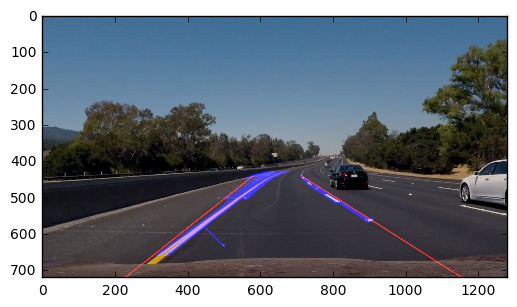

In [385]:
challenge_output = 'extra.mp4'
#clip2 = VideoFileClip('challenge.mp4').set_duration(3.7,change_end=True)
clip2 = VideoFileClip('challenge.mp4')
#clip2 = VideoFileClip('challenge.mp4').cutout(3.8,3.9)
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)